# **Implementation for Homework 1b**

## Introduction:
This code file is designed to carry out Homework 1b, which involves training and evaluating a Bidirectional Long Short-Term Memory (BiLSTM) model for text classification. The initial steps consist of setting up the environment, arranging the data, defining the model using pre-trained Word2Vec embeddings, training and evaluating the model using a Trainer class, managing hyperparameters with HyperParametersClass, and visualising performance metrics (loss, accuracy, precision, recall, F1 score) throughout the training epochs. The notebook provides a comprehensive workflow complemented by detailed notes and visual representations.



## Authors
- **Syed Saad Hasan**  
  Email: [hasan.2106512@studenti.uniroma1.it]

---

# Getting the Environment Ready

Begining from the checks for the required packages (numpy, torch, etc.) and installs any that are missing, and it also installs the Italian language model (it_core_news_sm) for spaCy.




In [13]:
import pkg_resources
from subprocess import call, check_output, CalledProcessError

# List of required packages
packages = [
    "numpy", "torch", "torchtext", "scikit-learn", "tabulate",
    "tqdm", "gensim", "huggingface_hub", "matplotlib", "gdown"
]

# Check and install packages if not already installed
for p in packages:
    try:
        # Check if the package is already installed
        dist = pkg_resources.get_distribution(p)
        print(f'{dist.key} ({dist.version}) is installed')
    except pkg_resources.DistributionNotFound:
        # Install the package if not installed
        print(f'{p} is NOT installed')
        call(f"pip install {p}", shell=True)

# Try to install the Italian language model for spaCy
try:
    check_output('python -m spacy download it_core_news_sm', shell=True)
    print("it_core_news_sm has been installed correctly!")
except CalledProcessError as e:
    print("Error: ", e.output)

numpy (1.25.2) is installed
torch (2.3.0+cu121) is installed
torchtext (0.18.0) is installed
scikit-learn (1.2.2) is installed
tabulate (0.9.0) is installed
tqdm (4.66.4) is installed
gensim (4.3.2) is installed
huggingface-hub (0.23.4) is installed
matplotlib (3.7.1) is installed
gdown (5.1.0) is installed
it_core_news_sm has been installed correctly!


In [14]:
#The %%capture command suppresses the output of this cell in a Jupyter Notebook
%%capture

# Import necessary libraries
import json
from google.colab import drive
import zipfile
import random
import numpy as np
from collections import Counter
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence
import copy
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,log_loss
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import gdown

**Code Functionality**
This script installs required packages (numpy, torch, etc.) and the Italian language model (it_core_news_sm) for spaCy.

**Device Configuration**
It checks for an NVIDIA GPU and sets the device to cuda if available, otherwise cpu. The chosen device is printed.

In [15]:
# Check if NVIDIA GPU is available
try:
    subprocess.check_output('nvidia-smi', shell=True)
    DEVICE = 'cuda'  # Set device to GPU if available
except subprocess.CalledProcessError:
    DEVICE = 'cpu'  # Fall back to CPU if GPU is not available

# Print the device that will be used for computation
print("We will use the device:", DEVICE)

We will use the device: cuda


Now we're good to go and sets a random seed for reproducibility across Python, NumPy, and PyTorch, ensuring deterministic behavior for CuDNN on GPUs..

In [16]:
# Set a random seed for reproducibility
SEED = 98766789

# Set the seed for Python's random module
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ensure deterministic behavior for CuDNN (GPU)
torch.backends.cudnn.deterministic = True

# Confirm seed setting
print("Random seeds set for reproducibility.")

Random seeds set for reproducibility.


Finally we import the italian word2vec model that we will use for both models

In [17]:
# Import the Italian Word2Vec model from Hugging Face Hub
# (https://huggingface.co/Word2vec/wikipedia2vec_itwiki_20180420_300d)
word2vec_model = KeyedVectors.load_word2vec_format(
    hf_hub_download(
        repo_id="Word2vec/wikipedia2vec_itwiki_20180420_300d",
        filename="itwiki_20180420_300d.txt"
    )
)

# Convert the Word2Vec embedding vectors to a PyTorch tensor
word_embeddings = torch.FloatTensor(word2vec_model.vectors)

# Store the embedding dimension size for later use
embedding_dim = word2vec_model.vector_size

# Print confirmation of successful loading and conversion
print("Word2Vec model loaded and converted to tensor. Embedding dimension:", embedding_dim)

Word2Vec model loaded and converted to tensor. Embedding dimension: 300


# Process the data


Initially, we get the data from the Drive folder, as accomplished in hw1_a.

In [20]:
# Mount Google Drive to access files stored in it
drive.mount('/content/drive')

# URL of the homework zip file stored in Google Drive
hw1a_url = 'https://drive.google.com/uc?id=1dMJghnFWehHexyEFUvrNgtzZigDmRo36'

# Download the zip file of homework 1a using gdown
gdown.download(hw1a_url)

# Path where the zip file is saved after download
zip_path = '/content/v2-HM1_A-2121502.zip'

# Extract the contents of the zip file to a specified directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/hw1b')

# Path to access the extracted jsonl files
data_path = '/content/hw1b/HM1_A-2121502/task-21-ironita'

# Load and parse the training jsonl file into a list
trainJSONL = []
with open(data_path + '/ironita-task1-train.jsonl', 'r') as f:
    for line in f:
        trainJSONL.append(json.loads(line))

# Load and parse the test jsonl file into a list
testJSONL = []
with open(data_path + '/ironita-task1-test.jsonl', 'r') as f:
    for line in f:
        testJSONL.append(json.loads(line))

# Print confirmation that the files have been successfully loaded
print("Training and test JSONL files have been successfully loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From: https://drive.google.com/uc?id=1dMJghnFWehHexyEFUvrNgtzZigDmRo36
To: /content/v2-HM1_A-2121502.zip
100%|██████████| 916k/916k [00:00<00:00, 119MB/s]

Training and test JSONL files have been successfully loaded.


In [21]:
# See the number of items of each jsonl
print(len(trainJSONL))
print(len(testJSONL))

# Check they have not the same information
print(trainJSONL[0])
print(testJSONL[0])

3977
872
{'sentence': 'Zurigo, trovato morto il presunto autore della sparatoria nel centro islamico #20dicembre <URL>', 'choices': ['non ironia', 'ironia'], 'label': 0}
{'sentence': '-Prendere i libri in copisteria-Fare la spesa-Spararmi in bocca-Farmi la doccia', 'choices': ['non ironia', 'ironia'], 'label': 1}


Create a validation set (in README of task 21 we were only asked to do train and test)

In [22]:
# Extract from the train jsonl the valid jsonl
testJSONL, validJSONL = train_test_split(testJSONL, test_size=len(testJSONL)//2)
# Now we have train validation and test datasets
print(len(trainJSONL))
print(len(testJSONL))
print(len(validJSONL))

3977
436
436


In [23]:
# Save the new JSONL datasets to files

# Save the training data to train.jsonl
with open('/content/hw1b/train.jsonl', 'w') as f:
    for entry in trainJSONL:
        f.write(json.dumps(entry) + '\n')

# Save the test data to test.jsonl
with open('/content/hw1b/test.jsonl', 'w') as f:
    for entry in testJSONL:
        f.write(json.dumps(entry) + '\n')

# Save the validation data to valid.jsonl
with open('/content/hw1b/valid.jsonl', 'w') as f:
    for entry in validJSONL:
        f.write(json.dumps(entry) + '\n')

# Print confirmation that files have been saved
print("Train, test, and validation JSONL files have been successfully saved.")

Train, test, and validation JSONL files have been successfully saved.


# Managing Dataset Class

In [24]:
# Create a class to contain hyperparameters for different classes
# This allows flexible hyperparameter management without altering the class itself

class HyperParametersClass:
    def __init__(self, **kwargs):
        # Initialize the class with any number of hyperparameters passed as keyword arguments
        for key, value in kwargs.items():
            # Set each hyperparameter as an attribute of the class instance
            setattr(self, key, value)

# Example usage:
# params = HyperParametersClass(learning_rate=0.001, batch_size=32, num_epochs=10)
# This will create an instance with attributes: params.learning_rate, params.batch_size, params.num_epochs

Sets the hyperparameters for the (hw1b_Dataset) class using the (HyperParametersClass) to allow flexible and easy configuration

In [28]:
# Initialize specific hyperparameters for hw1b_Dataset
hw1b_Dataset_HP = HyperParametersClass(
    path="",                # Path to the dataset (string)
    max_length=1028,        # Maximum length of sequences (integer)
    device=DEVICE,          # Device to be used (string: 'cuda' or 'cpu')
    pad_token="<pad>",      # Padding token (string)
    unk_token="<unk>",      # Unknown token (string)
    extra_tokens=[]         # List of extra tokens (list of strings)
)

# Print confirmation that hyperparameters have been set
print("Hyperparameters for HW1b_Dataset have been set.")

Hyperparameters for HW1b_Dataset have been set.


In [29]:
# Define a class for the datasets of the task
class hw1b_Dataset(Dataset):
    def __init__(self, hp: HyperParametersClass):
        # Initialize the dataset with hyperparameters from HyperParametersClass

        # Get an Italian tokenizer
        self.tokenizer = get_tokenizer("spacy", language='it')

        self.samples = self._load_samples(hp.path)
        self.vocabulary = self._build_vocabulary(hp)
        self.indexed_data = self._index_data(self.samples, self.vocabulary)

        # Set other class attributes
        self.max_length = hp.max_length
        self.device = torch.device(hp.device)
        self.padding_id = self.vocabulary([hp.pad_token])[0]

    def _load_samples(self, path):
        # Load and tokenize samples from the JSONL file
        samples = []
        token_list = []

        with open(path, "r") as f:
            for line in f:
                sample = json.loads(line)
                sample["tokens"] = self.tokenizer(sample["sentence"])
                samples.append(sample)
                token_list.extend(sample["tokens"])

        self.token_list = token_list
        return samples

    def _build_vocabulary(self, hp):
        # Build vocabulary from tokens
        counter = Counter(self.token_list)
        vocab_obj = vocab(counter, min_freq=1, specials=[hp.pad_token, hp.unk_token, *hp.extra_tokens])
        vocab_obj.set_default_index(vocab_obj[hp.unk_token])
        return vocab_obj

    def _index_data(self, samples, vocabulary):
        # Index the data using the vocabulary
        return [{"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]} for sample in samples]

    def __len__(self) -> int:
        # Return the number of samples in the dataset
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        # Get the sample at the specified index
        return self.indexed_data[idx]

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        # Save the length of each batch sample in a tensor
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)

        # Save the padded sequence of input_ids in a tensor
        padded_sequence = pad_sequence(
            [torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device) for sample in raw_batch],
            batch_first=True,
            padding_value=self.padding_id
        )

        # Save the labels of each batch sample in a tensor
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)

        return sequence_lengths, padded_sequence, labels

**Code initializes hyperparameters, creates datasets, and sets up DataLoaders for training, validation, and testing.**

In [30]:
# Create the hyperparameters for each Dataset by copying the base hyperparameters
hw1b_Dataset_HP_train = copy.deepcopy(hw1b_Dataset_HP)
hw1b_Dataset_HP_test = copy.deepcopy(hw1b_Dataset_HP)
hw1b_Dataset_HP_valid = copy.deepcopy(hw1b_Dataset_HP)

# Set the path for the training, testing, and validation datasets
hw1b_Dataset_HP_train.path = "/content/hw1b/train.jsonl"
hw1b_Dataset_HP_test.path = "/content/hw1b/test.jsonl"
hw1b_Dataset_HP_valid.path = "/content/hw1b/valid.jsonl"

# Create hw1b_Dataset objects for each dataset
train_dataset = hw1b_Dataset(hw1b_Dataset_HP_train)
validation_dataset = hw1b_Dataset(hw1b_Dataset_HP_test)
test_dataset = hw1b_Dataset(hw1b_Dataset_HP_valid)

# Create DataLoader objects for batching and shuffling the datasets
training_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False, collate_fn=validation_dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=test_dataset._collate_fn)

# Print confirmation that DataLoaders have been created
print("DataLoaders for training, validation, and testing have been successfully created.")

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "it" could not be loaded, trying "it_core_news_sm" instead
  warnings.warn(


DataLoaders for training, validation, and testing have been successfully created.


**Generate lists of labels and predictions for evaluation**

In [31]:
# Extract all labels from the training DataLoader
labels_list = [label for _, _, labels in training_dataloader for label in labels.tolist()]

# Create a list with random choices between 0 and 1 for each label
random_choice = [random.randint(0, 1) for _ in range(len(labels_list))]

# Create a list where each prediction is always 1
always_1 = [1] * len(labels_list)

# Create a list where each prediction is always 0
always_0 = [0] * len(labels_list)

# Print confirmation of list creation
print("Label and prediction lists have been successfully created.")

Label and prediction lists have been successfully created.


In [32]:
# Calculate the accuracy of different prediction strategies
# Calculate the accuracy for the random choices between 0 and 1
random_choice_accuracy = accuracy_score(labels_list, random_choice)
# Calculate the accuracy for the strategy that always predicts 1
always_1_accuracy = accuracy_score(labels_list, always_1)
# Calculate the accuracy for the strategy that always predicts 0
always_0_accuracy = accuracy_score(labels_list, always_0)

# Print the accuracies for comparison
print(f"Accuracy for random choice predictions: {random_choice_accuracy:.4f}")
print(f"Accuracy for always predicting 1: {always_1_accuracy:.4f}")
print(f"Accuracy for always predicting 0: {always_0_accuracy:.4f}")


Accuracy for random choice predictions: 0.5109
Accuracy for always predicting 1: 0.5087
Accuracy for always predicting 0: 0.4913


# Script involves LSTM models

Create the hyperparameter object for the LSTM model



In [42]:
LSTM_HP = HyperParametersClass(
    embedding_dim=embedding_dim,       # Dimension of the word embeddings
    hidden_dim=64,                     # Number of hidden units in the LSTM
    bilstm_layers=2,                   # Number of BiLSTM layers
    bilstm_dropout=0.5,                # Dropout rate for BiLSTM layers
    num_classes=2,                     # Number of output classes
    padding_id=train_dataset.padding_id, # Padding token ID
    device=DEVICE,                     # Device to run the model on (CPU or GPU)
    bidirectional=True,                # Use bidirectional LSTM
    word2vec_embeddings=word_embeddings # Pre-trained Word2Vec embeddings
)

# Print confirmation that the hyperparameters for the LSTM model have been set
print("Hyperparameters for the LSTM model have been successfully created.")

Hyperparameters for the LSTM model have been successfully created.


In [43]:
# Define a BiLSTM model class
class BiLSTMModel(nn.Module):
    def __init__(self, hparams) -> None:
        super().__init__()

        # Save hyperparameters in the object (self)
        self.hparams = hparams

        # Create an embedding layer with the Word2Vec embeddings, and set the padding index
        self.embedding = nn.Embedding.from_pretrained(
            self.hparams.word2vec_embeddings,
            padding_idx=self.hparams.padding_id,
            freeze=True  # Ensure embeddings are not trainable
        ).to(self.hparams.device)

        # Create the LSTM (or BiLSTM) layers based on hyperparameters
        self.bilstm = nn.LSTM(
            input_size=self.hparams.embedding_dim,
            hidden_size=self.hparams.hidden_dim,
            num_layers=self.hparams.bilstm_layers,
            batch_first=True,
            dropout=self.hparams.bilstm_dropout,
            bidirectional=self.hparams.bidirectional,
            device=self.hparams.device
        )

        # Create a dropout layer to prevent overfitting
        self.dropout = nn.Dropout(self.hparams.bilstm_dropout)

        # Determine LSTM output dimensions based on whether LSTM is bidirectional
        lstm_output_dim = self.hparams.hidden_dim * 2 if self.hparams.bidirectional else self.hparams.hidden_dim

        # Create a linear projection layer for classification
        self.projection = nn.Linear(
            in_features=lstm_output_dim,
            out_features=self.hparams.num_classes,
            device=self.hparams.device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the sequence lengths and input ids from the batch
        sequence_lengths, input_ids = batch

        #Embed the input tokens
        embeds = self.embedding(input_ids)

        #Apply dropout to the embeddings
        embeds = self.dropout(embeds)

        #Pack the padded sequence
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        #Pass the packed sequence through the BiLSTM layer
        packed_output, (hidden_state, _) = self.bilstm(packed)

        #Reshape the outputs of the BiLSTM layer
        if self.hparams.bidirectional:
            hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        else:
            hidden = hidden_state[-1, :, :]

        #Apply dropout to the hidden states
        hidden = self.dropout(hidden)

        #Pass the hidden states through the projection layer to get the logits
        logits = self.projection(hidden)

        return logits
#Print confirmation that the BiLSTM model class has been created
print("BiLSTM model class has been successfully created.")

BiLSTM model class has been successfully created.


Here **Trainer** class for training and evaluating a neural network model, including functionality for logging, early stopping, and saving the best model based on validation accuracy.

In [44]:
class Trainer():
    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_level: int = 3
    ):
        # Save the model, the optimizer and the loss function
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        # Save the log level
        self.log_level = log_level

        # The log level determines how much information is shown
        # 0: NOTHING is shown
        # 1: Shows anounces, progress bar for each epoch and the final train and validation loss and accuracy of each epoch
        # 2: Shows the previously metioned things and the evolving train accuracy and loss for each epoch
        # 3: Shows the previously metioned things, the evolving train recall, precision and f1 for each epoch
        #    and a table with all the train and validation metrics for each epoch

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1,
        early_stopper = 0,
        best_val_acc = False
    ) :
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.
            early_stopper: an integer to apply the early stopper callback. It means that when you have not improved your validation accuracy for x epochs, the training is stopped.
            best_val_acc: a boolean indicating if you want to keep the weights with the best validation accuracy (True) or you prefeer to keep the last weigths (False)
        Returns:
            train_metrics: a dictionary with some metrics of the model on the trainig dataset (loss, accuracy, precision, recall, f1)
            val_metrics:  a dictionary with some metrics of the model on the validaion dataset (loss, accuracy, precision, recall, f1)
        """
        # Check that the epoch value is correct
        assert epochs >= 1 and isinstance(epochs, int)

        if self.log_level > 0:
            # Anounce the start of the training
            print('Training ...')

        # Set the training loss value
        train_loss = 0.0

        # Create the empty dictionaries fo train and validation metrics
        train_metrics = {
            "train_losses": [],
            "train_acc": [],
            "train_precision": [],
            "train_recall": [],
            "train_f1": [],
        }

        val_metrics = {
            "val_losses": [],
            "val_acc": [],
            "val_precision": [],
            "val_recall": [],
            "val_f1": [],
        }

        if best_val_acc:
          # Prepare the variables to keep the best validation accuracy, its epoch and its wheights
          best_acc = 0.0
          best_acc_epoch = 0
          best_model_wts = copy.deepcopy(self.model.state_dict())


        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                # Anounce the epoch
                print("#"*100)
                print(' Epoch {:2d}'.format(epoch))

            # Set the metrics variables of the epoch
            epoch_loss = 0.0
            epoch_acc = 0.0
            epoch_precision = 0.0
            epoch_f1 = 0.0
            epoch_recall = 0.0

            # Train the model
            self.model.train()

            # Creates a progress bar with the batches to control how training is progressing
            if self.log_level >0:
              progress_bar = tqdm(train_dataloader)
            else:
              progress_bar = train_dataloader

            for step, (sequence_lengths, inputs, labels) in enumerate(progress_bar):
                # Set the gradient to 0
                self.optimizer.zero_grad()

                # Obtain the predictions and then the losses of the model
                predictions = self.model((sequence_lengths, inputs))
                sample_loss = self.loss_function(predictions, labels)

                # Train the model
                sample_loss.backward()
                self.optimizer.step()

                ## Sum the metrics to the epoch variable
                # Loss
                epoch_loss += sample_loss.cpu().tolist()

                # Accuracy
                sample_acc = self._compute_acc(predictions, labels)
                epoch_acc += sample_acc

                # Precision
                sample_precision = self._compute_precision(predictions,labels)
                epoch_precision += sample_precision

                # Recall
                sample_recall = self._compute_recall(predictions,labels)
                epoch_recall += sample_recall

                # F1
                sample_f1 = self._compute_f1(predictions,labels)
                epoch_f1 += sample_f1

                # Log level 3 (print all metrics)
                if self.log_level >2:
                    progress_bar.set_description("Train Loss: {:0.4f}\tTrain accuracy: {:0.4f}\tTrain precision: {:0.4f}\tTrain recall: {:0.4f}\tTrain F1: {:0.4f}".format(sample_loss,sample_acc,sample_precision,sample_recall,sample_f1))

                # Log level 2 (print loss and accuracy)
                elif self.log_level >1:
                    progress_bar.set_description("Train Loss: {:0.4f}\tTrain accuracy: {:0.4f}\t\t".format(sample_loss,sample_acc))

            # Calculate the average of the metrics
            avg_train_loss = epoch_loss / len(train_dataloader)
            avg_train_acc = epoch_acc / len(train_dataloader)
            avg_train_precision = epoch_precision / len(train_dataloader)
            avg_train_recall = epoch_recall / len(train_dataloader)
            avg_train_f1 = epoch_f1 / len(train_dataloader)

            # Calculate the validation average of the metrics
            avg_valid_loss,avg_valid_acc,avg_valid_precision,avg_valid_recall,avg_valid_f1 = self.evaluate(valid_dataloader)

            # Callback: Early stopping (stop the training)
            if early_stopper != 0 and len(val_metrics["val_acc"]) > early_stopper and  avg_valid_acc < best_acc and best_acc_epoch + early_stopper < epoch:
              if self.log_level > 0:
                print(f"Early stopping on epoch {epoch}")

              if best_val_acc:
                # Save the best validation accuracy weights on the model before finishing the training
                self.model.load_state_dict(best_model_wts)
                if self.log_level > 0:
                  print(f"Keeping best accuracy validation weights (epoch {best_acc_epoch})")

              return (train_metrics,val_metrics)

            # Callback: Keep best validation accuracy weights
            if avg_valid_acc > best_acc and best_val_acc:
                # Update the best accuracy variables
                best_acc = avg_valid_acc
                best_acc_epoch = epoch
                best_model_wts = copy.deepcopy(self.model.state_dict())

            # Save both training  an validation metrics
            train_metrics["train_losses"].append(avg_train_loss)
            train_metrics["train_acc"].append(avg_train_acc)
            train_metrics["train_precision"].append(avg_train_precision)
            train_metrics["train_recall"].append(avg_train_recall)
            train_metrics["train_f1"].append(avg_train_f1)

            val_metrics["val_losses"].append(avg_valid_loss)
            val_metrics["val_acc"].append(avg_valid_acc)
            val_metrics["val_precision"].append(avg_valid_precision)
            val_metrics["val_recall"].append(avg_valid_recall)
            val_metrics["val_f1"].append(avg_valid_f1)

            if self.log_level > 2:
              # Print a table with the metrics of this epoch
              table = [[avg_train_loss,avg_valid_loss],[avg_train_acc,avg_valid_acc],[avg_train_precision,avg_valid_precision],[avg_train_recall,avg_valid_recall],[avg_train_f1,avg_valid_f1]]
              table = [[round(val, 3) if isinstance(val, float) else val for val in sublist] for sublist in table]
              headers = ['  TRAIN   ', 'VALIDATION']
              rows = ["Loss", "Accuracy", "Precision", "Recall", "F1"]
              print(tabulate(table, headers,showindex = rows, tablefmt='pretty'))

            if self.log_level > 0:
                # Print the loss and accuracy of each epoch
                print('\n\t[Epoch: {:2d}] train loss = {:0.4f} \t train accuracy = {:0.4f}'.format(epoch, avg_train_loss,avg_train_acc))
                print('\t[Epoch: {:2d}] valid loss = {:0.4f} \t valid accuracy = {:0.4f}\n'.format(epoch, avg_valid_loss, avg_valid_acc))

        if self.log_level > 0:
            # Anounce the end of the training
            print('... Done!')
        if best_val_acc:
            # Keep the best validation accuracy weights
            self.model.load_state_dict(best_model_wts)
            if self.log_level > 0:
              print(f"Keeping best accuracy validation weights (epoch {best_acc_epoch})")


        return (train_metrics,val_metrics)


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # Compute the predictions
        predictions = torch.argmax(logits, dim=1)

        # Compare the predicted labels with the correct labels, tranform them to float,
        # obtain the mean and transform the tensor to a python list
        return torch.mean((predictions == labels).float()).tolist()

    def _compute_precision(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # Compute the predictions
        predictions = torch.argmax(logits, dim=1)
        # Tranform the predicted labels and the correct labels tensors to python
        # lists and compute the precision score
        return precision_score(predictions.tolist(),labels.tolist())

    def _compute_recall(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # Compute the predictions
        predictions = torch.argmax(logits, dim=1)
        # Tranform the predicted labels and the correct labels tensors to python
        # lists and compute the recall score
        return recall_score(predictions.tolist(),labels.tolist())

    def _compute_f1(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # Compute the predictions
        predictions = torch.argmax(logits, dim=1)
        # Tranform the predicted labels and the correct labels tensors to python
        # lists and compute the f1 score
        return f1_score(predictions.tolist(),labels.tolist())

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        # Set the metrics initial values
        valid_loss = 0.0
        valid_acc = 0.0
        valid_precision = 0.0
        valid_recall = 0.0
        valid_f1 = 0.0

        # Set the model in evaluation mode (avoid training the model)
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                # Obtain the elements of the batch
                sequence_lengths, inputs, labels = batch

                # Calculate the logits
                logits = self.model((sequence_lengths, inputs))

                # Calculate and sum each metric
                # Loss
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                # Accuracy
                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

                # Precision
                sample_precision = self._compute_precision(logits,labels)#1#precision_score(logits.detach().numpy(), labels)
                valid_precision += sample_precision

                # Recall
                sample_recall = self._compute_recall(logits,labels)#1#recall_score(logits, labels)
                valid_recall += sample_recall

                # F1
                sample_f1 = self._compute_f1(logits,labels)#1#f1_score(logits, labels)
                valid_f1 += sample_f1

        # Obtain the average value of each metric
        avg_valid_loss = valid_loss/len(valid_dataloader)
        avg_valid_acc = valid_acc/len(valid_dataloader)
        avg_valid_precision = valid_precision/len(valid_dataloader)
        avg_valid_recall = valid_recall/len(valid_dataloader)
        avg_valid_f1 = valid_f1/len(valid_dataloader)

        # Return the average value of each metric
        return avg_valid_loss,avg_valid_acc,avg_valid_precision,avg_valid_recall,avg_valid_f1

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            batch: a tuple of tensors
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
        """
        # Set the model in evaluation mode
        self.model.eval()
        with torch.no_grad():
          # Compute the logits and their predictions of the batch
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs)
            predictions = torch.argmax(logits, -1)
            return logits, predictions

# Training LSTM

In [45]:
# Create the LSTM model using the defined hyperparameters
irony_tagger = BiLSTMModel(LSTM_HP)

# Print confirmation that the LSTM model has been created
print("LSTM model (irony tagger) has been successfully created.")

LSTM model (irony tagger) has been successfully created.


In [46]:
# Create the trainer for the LSTM model

# Initialize the Trainer with the irony tagger model, an Adam optimizer, and a log level
trainer = Trainer(
    model=irony_tagger,
    optimizer=torch.optim.Adam(irony_tagger.parameters(), lr=0.0001),
    log_level=3
)

# Print confirmation that the Trainer has been created
print("Trainer for the LSTM model has been successfully created.")

Trainer for the LSTM model has been successfully created.


In [47]:
# Train the LSTM model
train_metrics,valid_metrics = trainer.train(training_dataloader,
                                            validation_dataloader,
                                            epochs=250,
                                            early_stopper = 75,
                                            best_val_acc=True)

Training ...
####################################################################################################
 Epoch  1


Train Loss: 0.7080	Train accuracy: 0.4444	Train precision: 0.7500	Train recall: 0.4286	Train F1: 0.5455: 100%|██████████| 32/32 [00:00<00:00, 45.33it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.693    |   0.691    |
| Accuracy  |   0.511    |   0.512    |
| Precision |   0.804    |   0.992    |
|  Recall   |   0.512    |   0.505    |
|    F1     |   0.624    |   0.669    |
+-----------+------------+------------+

	[Epoch:  1] train loss = 0.6933 	 train accuracy = 0.5107
	[Epoch:  1] valid loss = 0.6913 	 valid accuracy = 0.5116

####################################################################################################
 Epoch  2


Train Loss: 0.6821	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 46.06it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.691    |   0.691    |
| Accuracy  |   0.535    |   0.505    |
| Precision |    0.76    |   0.935    |
|  Recall   |   0.529    |   0.502    |
|    F1     |   0.623    |   0.653    |
+-----------+------------+------------+

	[Epoch:  2] train loss = 0.6906 	 train accuracy = 0.5345
	[Epoch:  2] valid loss = 0.6905 	 valid accuracy = 0.5048

####################################################################################################
 Epoch  3


Train Loss: 0.6728	Train accuracy: 0.6667	Train precision: 0.4000	Train recall: 1.0000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 48.02it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.688    |   0.689    |
| Accuracy  |   0.569    |   0.608    |
| Precision |   0.671    |   0.808    |
|  Recall   |   0.575    |   0.576    |
|    F1     |   0.611    |   0.672    |
+-----------+------------+------------+

	[Epoch:  3] train loss = 0.6875 	 train accuracy = 0.5692
	[Epoch:  3] valid loss = 0.6894 	 valid accuracy = 0.6079

####################################################################################################
 Epoch  4


Train Loss: 0.6812	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.7778	Train F1: 0.8750: 100%|██████████| 32/32 [00:00<00:00, 45.34it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.686    |   0.688    |
| Accuracy  |   0.581    |   0.603    |
| Precision |   0.686    |   0.791    |
|  Recall   |   0.576    |   0.574    |
|    F1     |   0.625    |   0.665    |
+-----------+------------+------------+

	[Epoch:  4] train loss = 0.6859 	 train accuracy = 0.5809
	[Epoch:  4] valid loss = 0.6880 	 valid accuracy = 0.6031

####################################################################################################
 Epoch  5


Train Loss: 0.6663	Train accuracy: 0.5556	Train precision: 0.6667	Train recall: 0.6667	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 46.23it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.681    |   0.686    |
| Accuracy  |   0.612    |   0.601    |
| Precision |   0.738    |   0.795    |
|  Recall   |   0.599    |   0.572    |
|    F1     |   0.659    |   0.665    |
+-----------+------------+------------+

	[Epoch:  5] train loss = 0.6806 	 train accuracy = 0.6116
	[Epoch:  5] valid loss = 0.6857 	 valid accuracy = 0.6011

####################################################################################################
 Epoch  6


Train Loss: 0.6745	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 47.16it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.673    |   0.681    |
| Accuracy  |   0.637    |   0.628    |
| Precision |   0.739    |   0.736    |
|  Recall   |   0.619    |   0.604    |
|    F1     |   0.673    |   0.663    |
+-----------+------------+------------+

	[Epoch:  6] train loss = 0.6730 	 train accuracy = 0.6368
	[Epoch:  6] valid loss = 0.6807 	 valid accuracy = 0.6283

####################################################################################################
 Epoch  7


Train Loss: 0.6403	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 47.64it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.657    |   0.671    |
| Accuracy  |   0.643    |   0.618    |
| Precision |   0.692    |   0.734    |
|  Recall   |   0.636    |   0.595    |
|    F1     |   0.657    |   0.657    |
+-----------+------------+------------+

	[Epoch:  7] train loss = 0.6566 	 train accuracy = 0.6431
	[Epoch:  7] valid loss = 0.6712 	 valid accuracy = 0.6178

####################################################################################################
 Epoch  8


Train Loss: 0.6298	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 44.28it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.634    |   0.657    |
| Accuracy  |   0.664    |   0.588    |
| Precision |    0.74    |   0.724    |
|  Recall   |   0.653    |   0.569    |
|    F1     |   0.691    |   0.637    |
+-----------+------------+------------+

	[Epoch:  8] train loss = 0.6338 	 train accuracy = 0.6637
	[Epoch:  8] valid loss = 0.6570 	 valid accuracy = 0.5877

####################################################################################################
 Epoch  9


Train Loss: 0.5964	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 38.80it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.621    |   0.655    |
| Accuracy  |   0.667    |   0.602    |
| Precision |   0.764    |    0.67    |
|  Recall   |   0.646    |    0.59    |
|    F1     |   0.698    |   0.627    |
+-----------+------------+------------+

	[Epoch:  9] train loss = 0.6206 	 train accuracy = 0.6671
	[Epoch:  9] valid loss = 0.6554 	 valid accuracy = 0.6023

####################################################################################################
 Epoch 10


Train Loss: 0.3726	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 34.66it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.605    |   0.659    |
| Accuracy  |   0.687    |   0.613    |
| Precision |   0.775    |   0.611    |
|  Recall   |   0.656    |   0.612    |
|    F1     |   0.708    |   0.611    |
+-----------+------------+------------+

	[Epoch: 10] train loss = 0.6052 	 train accuracy = 0.6874
	[Epoch: 10] valid loss = 0.6589 	 valid accuracy = 0.6128

####################################################################################################
 Epoch 11


Train Loss: 0.5134	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8571	Train F1: 0.9231: 100%|██████████| 32/32 [00:00<00:00, 34.01it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.606    |   0.662    |
| Accuracy  |   0.679    |   0.611    |
| Precision |   0.745    |   0.619    |
|  Recall   |   0.666    |   0.606    |
|    F1     |    0.7     |   0.612    |
+-----------+------------+------------+

	[Epoch: 11] train loss = 0.6059 	 train accuracy = 0.6791
	[Epoch: 11] valid loss = 0.6615 	 valid accuracy = 0.6109

####################################################################################################
 Epoch 12


Train Loss: 0.4905	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.7143	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 33.27it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.599    |   0.664    |
| Accuracy  |    0.68    |   0.586    |
| Precision |   0.768    |    0.77    |
|  Recall   |    0.66    |   0.562    |
|    F1     |   0.708    |    0.65    |
+-----------+------------+------------+

	[Epoch: 12] train loss = 0.5993 	 train accuracy = 0.6798
	[Epoch: 12] valid loss = 0.6645 	 valid accuracy = 0.5856

####################################################################################################
 Epoch 13


Train Loss: 0.3840	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 41.88it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.593    |   0.665    |
| Accuracy  |    0.68    |   0.632    |
| Precision |   0.754    |   0.588    |
|  Recall   |   0.661    |   0.641    |
|    F1     |   0.703    |   0.613    |
+-----------+------------+------------+

	[Epoch: 13] train loss = 0.5930 	 train accuracy = 0.6799
	[Epoch: 13] valid loss = 0.6653 	 valid accuracy = 0.6321

####################################################################################################
 Epoch 14


Train Loss: 0.6146	Train accuracy: 0.6667	Train precision: 0.6000	Train recall: 0.7500	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.25it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.589    |   0.672    |
| Accuracy  |   0.686    |   0.613    |
| Precision |   0.735    |   0.538    |
|  Recall   |    0.68    |   0.629    |
|    F1     |   0.703    |   0.579    |
+-----------+------------+------------+

	[Epoch: 14] train loss = 0.5890 	 train accuracy = 0.6856
	[Epoch: 14] valid loss = 0.6716 	 valid accuracy = 0.6127

####################################################################################################
 Epoch 15


Train Loss: 0.5847	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.7500	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 48.32it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.588    |   0.671    |
| Accuracy  |   0.684    |   0.608    |
| Precision |   0.721    |   0.583    |
|  Recall   |   0.684    |   0.611    |
|    F1     |   0.698    |   0.596    |
+-----------+------------+------------+

	[Epoch: 15] train loss = 0.5884 	 train accuracy = 0.6841
	[Epoch: 15] valid loss = 0.6710 	 valid accuracy = 0.6079

####################################################################################################
 Epoch 16


Train Loss: 0.5262	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8333	Train F1: 0.9091: 100%|██████████| 32/32 [00:00<00:00, 46.20it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.583    |    0.67    |
| Accuracy  |   0.694    |   0.613    |
| Precision |   0.753    |   0.576    |
|  Recall   |   0.681    |   0.618    |
|    F1     |   0.712    |   0.596    |
+-----------+------------+------------+

	[Epoch: 16] train loss = 0.5826 	 train accuracy = 0.6938
	[Epoch: 16] valid loss = 0.6703 	 valid accuracy = 0.6127

####################################################################################################
 Epoch 17


Train Loss: 0.5035	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.5000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 45.97it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.579    |   0.676    |
| Accuracy  |   0.679    |   0.604    |
| Precision |   0.712    |    0.47    |
|  Recall   |   0.672    |   0.638    |
|    F1     |   0.689    |   0.541    |
+-----------+------------+------------+

	[Epoch: 17] train loss = 0.5789 	 train accuracy = 0.6793
	[Epoch: 17] valid loss = 0.6763 	 valid accuracy = 0.6040

####################################################################################################
 Epoch 18


Train Loss: 0.4442	Train accuracy: 0.8889	Train precision: 0.7500	Train recall: 1.0000	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 46.90it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.577    |   0.672    |
| Accuracy  |   0.691    |   0.615    |
| Precision |    0.72    |   0.568    |
|  Recall   |   0.691    |   0.623    |
|    F1     |   0.702    |   0.593    |
+-----------+------------+------------+

	[Epoch: 18] train loss = 0.5766 	 train accuracy = 0.6906
	[Epoch: 18] valid loss = 0.6716 	 valid accuracy = 0.6146

####################################################################################################
 Epoch 19


Train Loss: 0.6691	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.6667	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 49.19it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.58    |   0.679    |
| Accuracy  |   0.683    |   0.596    |
| Precision |   0.718    |   0.446    |
|  Recall   |   0.675    |   0.633    |
|    F1     |   0.693    |   0.523    |
+-----------+------------+------------+

	[Epoch: 19] train loss = 0.5798 	 train accuracy = 0.6827
	[Epoch: 19] valid loss = 0.6786 	 valid accuracy = 0.5962

####################################################################################################
 Epoch 20


Train Loss: 0.7209	Train accuracy: 0.4444	Train precision: 0.3333	Train recall: 0.2500	Train F1: 0.2857: 100%|██████████| 32/32 [00:00<00:00, 44.97it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.577    |   0.682    |
| Accuracy  |   0.683    |   0.598    |
| Precision |   0.708    |   0.414    |
|  Recall   |   0.673    |   0.651    |
|    F1     |   0.688    |   0.506    |
+-----------+------------+------------+

	[Epoch: 20] train loss = 0.5773 	 train accuracy = 0.6831
	[Epoch: 20] valid loss = 0.6818 	 valid accuracy = 0.5981

####################################################################################################
 Epoch 21


Train Loss: 0.7585	Train accuracy: 0.4444	Train precision: 0.0000	Train recall: 0.0000	Train F1: 0.0000: 100%|██████████| 32/32 [00:00<00:00, 45.56it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.581    |   0.682    |
| Accuracy  |   0.682    |   0.588    |
| Precision |   0.686    |   0.391    |
|  Recall   |   0.671    |   0.642    |
|    F1     |   0.675    |   0.485    |
+-----------+------------+------------+

	[Epoch: 21] train loss = 0.5808 	 train accuracy = 0.6823
	[Epoch: 21] valid loss = 0.6820 	 valid accuracy = 0.5883

####################################################################################################
 Epoch 22


Train Loss: 0.8231	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 45.88it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.578    |   0.679    |
| Accuracy  |   0.683    |   0.598    |
| Precision |    0.7     |   0.476    |
|  Recall   |   0.689    |   0.627    |
|    F1     |   0.692    |   0.541    |
+-----------+------------+------------+

	[Epoch: 22] train loss = 0.5782 	 train accuracy = 0.6829
	[Epoch: 22] valid loss = 0.6793 	 valid accuracy = 0.5981

####################################################################################################
 Epoch 23


Train Loss: 0.6260	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.3333	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 48.67it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.569    |   0.685    |
| Accuracy  |   0.697    |   0.581    |
| Precision |   0.742    |   0.394    |
|  Recall   |   0.678    |   0.624    |
|    F1     |   0.702    |   0.483    |
+-----------+------------+------------+

	[Epoch: 23] train loss = 0.5691 	 train accuracy = 0.6967
	[Epoch: 23] valid loss = 0.6847 	 valid accuracy = 0.5805

####################################################################################################
 Epoch 24


Train Loss: 0.7148	Train accuracy: 0.5556	Train precision: 0.8000	Train recall: 0.5714	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.24it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.573    |   0.676    |
| Accuracy  |   0.688    |   0.604    |
| Precision |   0.695    |   0.571    |
|  Recall   |   0.695    |   0.609    |
|    F1     |   0.691    |   0.589    |
+-----------+------------+------------+

	[Epoch: 24] train loss = 0.5734 	 train accuracy = 0.6880
	[Epoch: 24] valid loss = 0.6761 	 valid accuracy = 0.6040

####################################################################################################
 Epoch 25


Train Loss: 0.5418	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 43.24it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.567    |   0.675    |
| Accuracy  |   0.684    |   0.604    |
| Precision |    0.71    |    0.54    |
|  Recall   |   0.679    |   0.619    |
|    F1     |   0.688    |   0.576    |
+-----------+------------+------------+

	[Epoch: 25] train loss = 0.5666 	 train accuracy = 0.6845
	[Epoch: 25] valid loss = 0.6753 	 valid accuracy = 0.6041

####################################################################################################
 Epoch 26


Train Loss: 0.7556	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 1.0000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 39.13it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.574    |   0.675    |
| Accuracy  |   0.685    |    0.6     |
| Precision |   0.681    |   0.579    |
|  Recall   |   0.712    |   0.603    |
|    F1     |    0.69    |    0.59    |
+-----------+------------+------------+

	[Epoch: 26] train loss = 0.5737 	 train accuracy = 0.6848
	[Epoch: 26] valid loss = 0.6752 	 valid accuracy = 0.6001

####################################################################################################
 Epoch 27


Train Loss: 0.3462	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 33.96it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.557    |   0.676    |
| Accuracy  |   0.704    |   0.612    |
| Precision |   0.762    |   0.479    |
|  Recall   |   0.691    |   0.651    |
|    F1     |   0.722    |   0.551    |
+-----------+------------+------------+

	[Epoch: 27] train loss = 0.5574 	 train accuracy = 0.7043
	[Epoch: 27] valid loss = 0.6764 	 valid accuracy = 0.6118

####################################################################################################
 Epoch 28


Train Loss: 0.4825	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 1.0000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 33.41it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.558    |    0.68    |
| Accuracy  |   0.704    |   0.603    |
| Precision |   0.732    |   0.576    |
|  Recall   |   0.711    |   0.606    |
|    F1     |   0.716    |    0.59    |
+-----------+------------+------------+

	[Epoch: 28] train loss = 0.5579 	 train accuracy = 0.7042
	[Epoch: 28] valid loss = 0.6801 	 valid accuracy = 0.6029

####################################################################################################
 Epoch 29


Train Loss: 0.3602	Train accuracy: 0.8889	Train precision: 0.8000	Train recall: 1.0000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 35.09it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.55    |    0.68    |
| Accuracy  |   0.704    |   0.591    |
| Precision |   0.723    |   0.629    |
|  Recall   |   0.708    |   0.584    |
|    F1     |   0.712    |   0.605    |
+-----------+------------+------------+

	[Epoch: 29] train loss = 0.5501 	 train accuracy = 0.7043
	[Epoch: 29] valid loss = 0.6795 	 valid accuracy = 0.5913

####################################################################################################
 Epoch 30


Train Loss: 0.3571	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 36.42it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.553    |    0.68    |
| Accuracy  |    0.71    |   0.594    |
| Precision |   0.735    |   0.477    |
|  Recall   |   0.704    |   0.621    |
|    F1     |   0.717    |   0.538    |
+-----------+------------+------------+

	[Epoch: 30] train loss = 0.5532 	 train accuracy = 0.7104
	[Epoch: 30] valid loss = 0.6801 	 valid accuracy = 0.5942

####################################################################################################
 Epoch 31


Train Loss: 0.4501	Train accuracy: 0.7778	Train precision: 0.6000	Train recall: 1.0000	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 46.98it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.548    |   0.685    |
| Accuracy  |   0.706    |   0.588    |
| Precision |   0.718    |    0.44    |
|  Recall   |   0.714    |   0.625    |
|    F1     |   0.712    |   0.515    |
+-----------+------------+------------+

	[Epoch: 31] train loss = 0.5477 	 train accuracy = 0.7059
	[Epoch: 31] valid loss = 0.6847 	 valid accuracy = 0.5883

####################################################################################################
 Epoch 32


Train Loss: 0.5052	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.6000	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 46.59it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.556    |   0.681    |
| Accuracy  |   0.698    |   0.586    |
| Precision |   0.726    |   0.551    |
|  Recall   |   0.697    |   0.592    |
|    F1     |   0.707    |   0.569    |
+-----------+------------+------------+

	[Epoch: 32] train loss = 0.5561 	 train accuracy = 0.6984
	[Epoch: 32] valid loss = 0.6807 	 valid accuracy = 0.5864

####################################################################################################
 Epoch 33


Train Loss: 0.5835	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.27it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.555    |    0.68    |
| Accuracy  |   0.701    |   0.581    |
| Precision |   0.721    |   0.637    |
|  Recall   |    0.7     |   0.571    |
|    F1     |   0.705    |   0.602    |
+-----------+------------+------------+

	[Epoch: 33] train loss = 0.5545 	 train accuracy = 0.7008
	[Epoch: 33] valid loss = 0.6796 	 valid accuracy = 0.5807

####################################################################################################
 Epoch 34


Train Loss: 0.6175	Train accuracy: 0.5556	Train precision: 0.7500	Train recall: 0.5000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 45.32it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.55    |    0.69    |
| Accuracy  |   0.708    |   0.583    |
| Precision |   0.737    |   0.389    |
|  Recall   |   0.707    |   0.633    |
|    F1     |   0.718    |   0.481    |
+-----------+------------+------------+

	[Epoch: 34] train loss = 0.5497 	 train accuracy = 0.7080
	[Epoch: 34] valid loss = 0.6904 	 valid accuracy = 0.5826

####################################################################################################
 Epoch 35


Train Loss: 0.7324	Train accuracy: 0.4444	Train precision: 0.2000	Train recall: 0.5000	Train F1: 0.2857: 100%|██████████| 32/32 [00:00<00:00, 46.84it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.552    |   0.694    |
| Accuracy  |   0.699    |   0.568    |
| Precision |   0.684    |   0.731    |
|  Recall   |   0.713    |    0.55    |
|    F1     |   0.694    |   0.627    |
+-----------+------------+------------+

	[Epoch: 35] train loss = 0.5524 	 train accuracy = 0.6992
	[Epoch: 35] valid loss = 0.6938 	 valid accuracy = 0.5681

####################################################################################################
 Epoch 36


Train Loss: 0.5506	Train accuracy: 0.7778	Train precision: 0.8000	Train recall: 0.8000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 46.98it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.557    |   0.681    |
| Accuracy  |    0.7     |   0.586    |
| Precision |   0.725    |   0.646    |
|  Recall   |   0.701    |   0.575    |
|    F1     |    0.71    |   0.608    |
+-----------+------------+------------+

	[Epoch: 36] train loss = 0.5567 	 train accuracy = 0.6996
	[Epoch: 36] valid loss = 0.6811 	 valid accuracy = 0.5864

####################################################################################################
 Epoch 37


Train Loss: 0.4113	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 44.14it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |   0.688    |
| Accuracy  |   0.717    |    0.59    |
| Precision |   0.741    |   0.461    |
|  Recall   |   0.712    |   0.622    |
|    F1     |   0.724    |   0.527    |
+-----------+------------+------------+

	[Epoch: 37] train loss = 0.5434 	 train accuracy = 0.7172
	[Epoch: 37] valid loss = 0.6881 	 valid accuracy = 0.5903

####################################################################################################
 Epoch 38


Train Loss: 0.5849	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.5000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 46.19it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.546    |   0.695    |
| Accuracy  |   0.714    |   0.592    |
| Precision |   0.714    |   0.448    |
|  Recall   |   0.715    |   0.633    |
|    F1     |   0.713    |   0.522    |
+-----------+------------+------------+

	[Epoch: 38] train loss = 0.5462 	 train accuracy = 0.7139
	[Epoch: 38] valid loss = 0.6947 	 valid accuracy = 0.5922

####################################################################################################
 Epoch 39


Train Loss: 0.5951	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 47.05it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.547    |   0.689    |
| Accuracy  |   0.707    |   0.566    |
| Precision |   0.699    |   0.608    |
|  Recall   |   0.722    |    0.56    |
|    F1     |   0.708    |   0.582    |
+-----------+------------+------------+

	[Epoch: 39] train loss = 0.5474 	 train accuracy = 0.7071
	[Epoch: 39] valid loss = 0.6886 	 valid accuracy = 0.5661

####################################################################################################
 Epoch 40


Train Loss: 0.6624	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.5714	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 47.11it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.555    |   0.684    |
| Accuracy  |   0.702    |   0.585    |
| Precision |   0.723    |   0.552    |
|  Recall   |   0.703    |   0.592    |
|    F1     |   0.709    |   0.568    |
+-----------+------------+------------+

	[Epoch: 40] train loss = 0.5545 	 train accuracy = 0.7022
	[Epoch: 40] valid loss = 0.6840 	 valid accuracy = 0.5855

####################################################################################################
 Epoch 41


Train Loss: 0.6528	Train accuracy: 0.4444	Train precision: 0.3333	Train recall: 0.6667	Train F1: 0.4444: 100%|██████████| 32/32 [00:00<00:00, 45.10it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.542    |    0.69    |
| Accuracy  |    0.71    |   0.587    |
| Precision |   0.722    |   0.498    |
|  Recall   |   0.717    |    0.61    |
|    F1     |   0.715    |   0.545    |
+-----------+------------+------------+

	[Epoch: 41] train loss = 0.5417 	 train accuracy = 0.7099
	[Epoch: 41] valid loss = 0.6899 	 valid accuracy = 0.5874

####################################################################################################
 Epoch 42


Train Loss: 0.3928	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.6667	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 45.79it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |   0.692    |
| Accuracy  |   0.712    |   0.564    |
| Precision |   0.739    |    0.67    |
|  Recall   |   0.711    |   0.552    |
|    F1     |    0.72    |   0.604    |
+-----------+------------+------------+

	[Epoch: 42] train loss = 0.5426 	 train accuracy = 0.7123
	[Epoch: 42] valid loss = 0.6919 	 valid accuracy = 0.5642

####################################################################################################
 Epoch 43


Train Loss: 0.3380	Train accuracy: 0.7778	Train precision: 0.6667	Train recall: 1.0000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 45.49it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.529    |   0.696    |
| Accuracy  |   0.718    |   0.571    |
| Precision |   0.732    |   0.568    |
|  Recall   |   0.724    |    0.57    |
|    F1     |   0.725    |   0.567    |
+-----------+------------+------------+

	[Epoch: 43] train loss = 0.5288 	 train accuracy = 0.7184
	[Epoch: 43] valid loss = 0.6956 	 valid accuracy = 0.5709

####################################################################################################
 Epoch 44


Train Loss: 0.3247	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 34.50it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.535    |   0.693    |
| Accuracy  |   0.717    |   0.584    |
| Precision |   0.734    |   0.519    |
|  Recall   |   0.716    |   0.597    |
|    F1     |   0.723    |   0.552    |
+-----------+------------+------------+

	[Epoch: 44] train loss = 0.5348 	 train accuracy = 0.7172
	[Epoch: 44] valid loss = 0.6925 	 valid accuracy = 0.5835

####################################################################################################
 Epoch 45


Train Loss: 0.4945	Train accuracy: 0.7778	Train precision: 0.8333	Train recall: 0.8333	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 35.59it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.541    |   0.691    |
| Accuracy  |   0.716    |   0.565    |
| Precision |   0.726    |   0.539    |
|  Recall   |   0.722    |   0.568    |
|    F1     |   0.722    |   0.551    |
+-----------+------------+------------+

	[Epoch: 45] train loss = 0.5411 	 train accuracy = 0.7162
	[Epoch: 45] valid loss = 0.6914 	 valid accuracy = 0.5651

####################################################################################################
 Epoch 46


Train Loss: 0.4307	Train accuracy: 0.7778	Train precision: 0.8571	Train recall: 0.8571	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 33.53it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.539    |   0.694    |
| Accuracy  |   0.722    |   0.554    |
| Precision |   0.736    |   0.604    |
|  Recall   |   0.725    |   0.549    |
|    F1     |   0.729    |   0.574    |
+-----------+------------+------------+

	[Epoch: 46] train loss = 0.5389 	 train accuracy = 0.7221
	[Epoch: 46] valid loss = 0.6938 	 valid accuracy = 0.5544

####################################################################################################
 Epoch 47


Train Loss: 0.6846	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |    0.7     |
| Accuracy  |   0.722    |   0.556    |
| Precision |   0.728    |    0.6     |
|  Recall   |    0.73    |   0.551    |
|    F1     |   0.727    |   0.573    |
+-----------+------------+------------+

	[Epoch: 47] train loss = 0.5433 	 train accuracy = 0.7215
	[Epoch: 47] valid loss = 0.7000 	 valid accuracy = 0.5563

####################################################################################################
 Epoch 48


Train Loss: 0.9010	Train accuracy: 0.4444	Train precision: 0.6667	Train recall: 0.3333	Train F1: 0.4444: 100%|██████████| 32/32 [00:00<00:00, 46.19it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.548    |   0.692    |
| Accuracy  |   0.712    |    0.55    |
| Precision |   0.731    |   0.547    |
|  Recall   |   0.714    |    0.55    |
|    F1     |   0.717    |   0.547    |
+-----------+------------+------------+

	[Epoch: 48] train loss = 0.5479 	 train accuracy = 0.7121
	[Epoch: 48] valid loss = 0.6923 	 valid accuracy = 0.5505

####################################################################################################
 Epoch 49


Train Loss: 0.7542	Train accuracy: 0.5556	Train precision: 0.4000	Train recall: 0.6667	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 44.67it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.545    |   0.695    |
| Accuracy  |   0.713    |   0.558    |
| Precision |   0.692    |   0.572    |
|  Recall   |   0.734    |   0.556    |
|    F1     |   0.709    |   0.562    |
+-----------+------------+------------+

	[Epoch: 49] train loss = 0.5446 	 train accuracy = 0.7134
	[Epoch: 49] valid loss = 0.6950 	 valid accuracy = 0.5583

####################################################################################################
 Epoch 50


Train Loss: 0.7048	Train accuracy: 0.6667	Train precision: 0.4000	Train recall: 1.0000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 44.99it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.539    |   0.699    |
| Accuracy  |   0.719    |   0.556    |
| Precision |    0.72    |   0.588    |
|  Recall   |   0.733    |   0.552    |
|    F1     |   0.719    |   0.568    |
+-----------+------------+------------+

	[Epoch: 50] train loss = 0.5386 	 train accuracy = 0.7191
	[Epoch: 50] valid loss = 0.6992 	 valid accuracy = 0.5563

####################################################################################################
 Epoch 51


Train Loss: 0.6913	Train accuracy: 0.5556	Train precision: 0.3333	Train recall: 0.3333	Train F1: 0.3333: 100%|██████████| 32/32 [00:00<00:00, 44.52it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.546    |   0.699    |
| Accuracy  |   0.709    |   0.568    |
| Precision |    0.73    |   0.506    |
|  Recall   |    0.7     |   0.579    |
|    F1     |   0.712    |   0.537    |
+-----------+------------+------------+

	[Epoch: 51] train loss = 0.5457 	 train accuracy = 0.7090
	[Epoch: 51] valid loss = 0.6988 	 valid accuracy = 0.5681

####################################################################################################
 Epoch 52


Train Loss: 0.6114	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 46.83it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.54    |   0.702    |
| Accuracy  |   0.708    |   0.567    |
| Precision |   0.704    |   0.455    |
|  Recall   |   0.716    |   0.587    |
|    F1     |   0.708    |   0.511    |
+-----------+------------+------------+

	[Epoch: 52] train loss = 0.5405 	 train accuracy = 0.7081
	[Epoch: 52] valid loss = 0.7017 	 valid accuracy = 0.5670

####################################################################################################
 Epoch 53


Train Loss: 0.6390	Train accuracy: 0.5556	Train precision: 0.5714	Train recall: 0.8000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 47.21it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.539    |   0.699    |
| Accuracy  |   0.713    |   0.564    |
| Precision |   0.714    |   0.564    |
|  Recall   |    0.73    |   0.562    |
|    F1     |   0.719    |   0.562    |
+-----------+------------+------------+

	[Epoch: 53] train loss = 0.5391 	 train accuracy = 0.7134
	[Epoch: 53] valid loss = 0.6987 	 valid accuracy = 0.5640

####################################################################################################
 Epoch 54


Train Loss: 0.5174	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 45.55it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.534    |   0.708    |
| Accuracy  |   0.718    |   0.549    |
| Precision |   0.718    |   0.673    |
|  Recall   |    0.73    |   0.538    |
|    F1     |   0.721    |   0.597    |
+-----------+------------+------------+

	[Epoch: 54] train loss = 0.5337 	 train accuracy = 0.7183
	[Epoch: 54] valid loss = 0.7079 	 valid accuracy = 0.5487

####################################################################################################
 Epoch 55


Train Loss: 0.5520	Train accuracy: 0.5556	Train precision: 0.6000	Train recall: 0.6000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 44.01it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.536    |   0.702    |
| Accuracy  |   0.713    |   0.556    |
| Precision |   0.731    |   0.589    |
|  Recall   |   0.715    |   0.552    |
|    F1     |    0.72    |   0.568    |
+-----------+------------+------------+

	[Epoch: 55] train loss = 0.5363 	 train accuracy = 0.7132
	[Epoch: 55] valid loss = 0.7017 	 valid accuracy = 0.5563

####################################################################################################
 Epoch 56


Train Loss: 0.5360	Train accuracy: 0.6667	Train precision: 0.5714	Train recall: 1.0000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 45.97it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.529    |   0.717    |
| Accuracy  |   0.721    |    0.56    |
| Precision |   0.721    |   0.747    |
|  Recall   |   0.737    |   0.544    |
|    F1     |   0.725    |   0.629    |
+-----------+------------+------------+

	[Epoch: 56] train loss = 0.5287 	 train accuracy = 0.7205
	[Epoch: 56] valid loss = 0.7174 	 valid accuracy = 0.5604

####################################################################################################
 Epoch 57


Train Loss: 0.2407	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 47.68it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.519    |    0.71    |
| Accuracy  |   0.732    |   0.554    |
| Precision |   0.751    |   0.592    |
|  Recall   |   0.731    |   0.549    |
|    F1     |   0.738    |   0.569    |
+-----------+------------+------------+

	[Epoch: 57] train loss = 0.5185 	 train accuracy = 0.7324
	[Epoch: 57] valid loss = 0.7101 	 valid accuracy = 0.5544

####################################################################################################
 Epoch 58


Train Loss: 0.6407	Train accuracy: 0.6667	Train precision: 0.3333	Train recall: 0.5000	Train F1: 0.4000: 100%|██████████| 32/32 [00:00<00:00, 45.42it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.528    |   0.714    |
| Accuracy  |   0.722    |   0.533    |
| Precision |   0.725    |   0.501    |
|  Recall   |   0.719    |   0.535    |
|    F1     |    0.72    |   0.516    |
+-----------+------------+------------+

	[Epoch: 58] train loss = 0.5278 	 train accuracy = 0.7225
	[Epoch: 58] valid loss = 0.7142 	 valid accuracy = 0.5331

####################################################################################################
 Epoch 59


Train Loss: 0.5244	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 44.19it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.527    |   0.713    |
| Accuracy  |   0.722    |   0.539    |
| Precision |   0.729    |   0.644    |
|  Recall   |   0.726    |   0.532    |
|    F1     |   0.725    |   0.582    |
+-----------+------------+------------+

	[Epoch: 59] train loss = 0.5269 	 train accuracy = 0.7222
	[Epoch: 59] valid loss = 0.7130 	 valid accuracy = 0.5389

####################################################################################################
 Epoch 60


Train Loss: 0.8133	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 44.47it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.53    |   0.713    |
| Accuracy  |   0.725    |   0.537    |
| Precision |    0.72    |   0.648    |
|  Recall   |   0.732    |    0.53    |
|    F1     |   0.724    |   0.582    |
+-----------+------------+------------+

	[Epoch: 60] train loss = 0.5299 	 train accuracy = 0.7249
	[Epoch: 60] valid loss = 0.7128 	 valid accuracy = 0.5370

####################################################################################################
 Epoch 61


Train Loss: 0.4720	Train accuracy: 0.7656	Train precision: 0.8333	Train recall: 0.7432	Train F1: 0.7857:  88%|████████▊ | 28/32 [00:00<00:00, 34.14it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Train Loss: 0.7520	Train accuracy: 0.6667	Train precision: 0.0000	Train recall: 0.0000	Train F1: 0.0000: 100%|██████████| 32/32 [00:00<00:00, 33.77it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.529    |   0.716    |
| Accuracy  |   0.727    |   0.553    |
| Precision |    0.73    |   0.407    |
|  Recall   |   0.704    |   0.574    |
|    F1     |   0.714    |   0.476    |
+-----------+------------+------------+

	[Epoch: 61] train loss = 0.5289 	 train accuracy = 0.7274
	[Epoch: 61] valid loss = 0.7157 	 valid accuracy = 0.5526

####################################################################################################
 Epoch 62


Train Loss: 0.5147	Train accuracy: 0.5556	Train precision: 0.6667	Train recall: 0.4000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 33.79it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.538    |   0.695    |
| Accuracy  |   0.708    |   0.555    |
| Precision |   0.685    |   0.542    |
|  Recall   |   0.736    |   0.556    |
|    F1     |   0.698    |   0.548    |
+-----------+------------+------------+

	[Epoch: 62] train loss = 0.5378 	 train accuracy = 0.7080
	[Epoch: 62] valid loss = 0.6951 	 valid accuracy = 0.5554

####################################################################################################
 Epoch 63


Train Loss: 0.2202	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 33.54it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.511    |   0.713    |
| Accuracy  |   0.736    |   0.543    |
| Precision |   0.739    |   0.559    |
|  Recall   |   0.741    |   0.541    |
|    F1     |   0.738    |   0.548    |
+-----------+------------+------------+

	[Epoch: 63] train loss = 0.5113 	 train accuracy = 0.7358
	[Epoch: 63] valid loss = 0.7128 	 valid accuracy = 0.5428

####################################################################################################
 Epoch 64


Train Loss: 0.5966	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.6667	Train F1: 0.5714: 100%|██████████| 32/32 [00:01<00:00, 30.71it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.525    |   0.719    |
| Accuracy  |   0.724    |   0.543    |
| Precision |   0.722    |   0.612    |
|  Recall   |   0.728    |   0.537    |
|    F1     |   0.723    |   0.571    |
+-----------+------------+------------+

	[Epoch: 64] train loss = 0.5253 	 train accuracy = 0.7237
	[Epoch: 64] valid loss = 0.7191 	 valid accuracy = 0.5428

####################################################################################################
 Epoch 65


Train Loss: 0.5962	Train accuracy: 0.7778	Train precision: 0.6667	Train recall: 1.0000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 40.77it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.525    |   0.715    |
| Accuracy  |   0.731    |   0.549    |
| Precision |   0.737    |   0.441    |
|  Recall   |    0.74    |   0.561    |
|    F1     |   0.734    |   0.494    |
+-----------+------------+------------+

	[Epoch: 65] train loss = 0.5251 	 train accuracy = 0.7308
	[Epoch: 65] valid loss = 0.7155 	 valid accuracy = 0.5485

####################################################################################################
 Epoch 66


Train Loss: 0.3714	Train accuracy: 0.7778	Train precision: 0.5000	Train recall: 1.0000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.75it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.521    |   0.714    |
| Accuracy  |   0.732    |   0.542    |
| Precision |   0.731    |   0.492    |
|  Recall   |   0.744    |   0.545    |
|    F1     |   0.732    |   0.516    |
+-----------+------------+------------+

	[Epoch: 66] train loss = 0.5205 	 train accuracy = 0.7318
	[Epoch: 66] valid loss = 0.7136 	 valid accuracy = 0.5418

####################################################################################################
 Epoch 67


Train Loss: 0.5925	Train accuracy: 0.6667	Train precision: 0.8000	Train recall: 0.6667	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 44.94it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.527    |   0.709    |
| Accuracy  |   0.723    |   0.546    |
| Precision |   0.741    |    0.57    |
|  Recall   |   0.726    |   0.544    |
|    F1     |    0.73    |   0.556    |
+-----------+------------+------------+

	[Epoch: 67] train loss = 0.5271 	 train accuracy = 0.7230
	[Epoch: 67] valid loss = 0.7090 	 valid accuracy = 0.5458

####################################################################################################
 Epoch 68


Train Loss: 0.3881	Train accuracy: 0.7778	Train precision: 0.8000	Train recall: 0.8000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 43.85it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.513    |   0.712    |
| Accuracy  |   0.734    |   0.544    |
| Precision |   0.736    |   0.641    |
|  Recall   |   0.742    |   0.535    |
|    F1     |   0.737    |   0.583    |
+-----------+------------+------------+

	[Epoch: 68] train loss = 0.5134 	 train accuracy = 0.7343
	[Epoch: 68] valid loss = 0.7119 	 valid accuracy = 0.5437

####################################################################################################
 Epoch 69


Train Loss: 0.4575	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 44.05it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.519    |   0.722    |
| Accuracy  |   0.732    |   0.537    |
| Precision |   0.731    |   0.453    |
|  Recall   |   0.736    |   0.544    |
|    F1     |   0.731    |   0.494    |
+-----------+------------+------------+

	[Epoch: 69] train loss = 0.5193 	 train accuracy = 0.7321
	[Epoch: 69] valid loss = 0.7217 	 valid accuracy = 0.5370

####################################################################################################
 Epoch 70


Train Loss: 0.4646	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 44.60it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.52    |    0.72    |
| Accuracy  |   0.724    |   0.545    |
| Precision |   0.716    |   0.666    |
|  Recall   |   0.735    |   0.535    |
|    F1     |   0.722    |   0.592    |
+-----------+------------+------------+

	[Epoch: 70] train loss = 0.5204 	 train accuracy = 0.7241
	[Epoch: 70] valid loss = 0.7204 	 valid accuracy = 0.5446

####################################################################################################
 Epoch 71


Train Loss: 0.6225	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.3333	Train F1: 0.4000: 100%|██████████| 32/32 [00:00<00:00, 47.25it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.519    |   0.721    |
| Accuracy  |   0.733    |   0.537    |
| Precision |   0.734    |   0.545    |
|  Recall   |   0.727    |   0.537    |
|    F1     |   0.728    |    0.54    |
+-----------+------------+------------+

	[Epoch: 71] train loss = 0.5187 	 train accuracy = 0.7335
	[Epoch: 71] valid loss = 0.7208 	 valid accuracy = 0.5371

####################################################################################################
 Epoch 72


Train Loss: 0.6135	Train accuracy: 0.5556	Train precision: 0.4000	Train recall: 0.6667	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 44.10it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.517    |   0.725    |
| Accuracy  |   0.731    |   0.532    |
| Precision |   0.724    |   0.661    |
|  Recall   |   0.742    |   0.525    |
|    F1     |    0.73    |   0.584    |
+-----------+------------+------------+

	[Epoch: 72] train loss = 0.5172 	 train accuracy = 0.7307
	[Epoch: 72] valid loss = 0.7254 	 valid accuracy = 0.5320

####################################################################################################
 Epoch 73


Train Loss: 0.8139	Train accuracy: 0.5556	Train precision: 0.5556	Train recall: 1.0000	Train F1: 0.7143: 100%|██████████| 32/32 [00:00<00:00, 44.18it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.525    |    0.73    |
| Accuracy  |   0.725    |   0.543    |
| Precision |   0.744    |   0.694    |
|  Recall   |   0.737    |   0.532    |
|    F1     |   0.737    |   0.601    |
+-----------+------------+------------+

	[Epoch: 73] train loss = 0.5254 	 train accuracy = 0.7251
	[Epoch: 73] valid loss = 0.7305 	 valid accuracy = 0.5427

####################################################################################################
 Epoch 74


Train Loss: 0.3823	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.6667	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 43.33it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.517    |   0.717    |
| Accuracy  |   0.733    |   0.536    |
| Precision |   0.741    |   0.661    |
|  Recall   |   0.736    |   0.528    |
|    F1     |   0.731    |   0.586    |
+-----------+------------+------------+

	[Epoch: 74] train loss = 0.5174 	 train accuracy = 0.7333
	[Epoch: 74] valid loss = 0.7168 	 valid accuracy = 0.5359

####################################################################################################
 Epoch 75


Train Loss: 0.6419	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 46.43it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.518    |   0.724    |
| Accuracy  |    0.73    |   0.528    |
| Precision |   0.741    |   0.511    |
|  Recall   |   0.733    |    0.53    |
|    F1     |   0.735    |    0.52    |
+-----------+------------+------------+

	[Epoch: 75] train loss = 0.5178 	 train accuracy = 0.7303
	[Epoch: 75] valid loss = 0.7239 	 valid accuracy = 0.5284

####################################################################################################
 Epoch 76


Train Loss: 0.5058	Train accuracy: 0.5556	Train precision: 0.4000	Train recall: 0.6667	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 45.47it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.508    |   0.724    |
| Accuracy  |   0.736    |   0.552    |
| Precision |   0.731    |   0.625    |
|  Recall   |   0.749    |   0.543    |
|    F1     |   0.737    |   0.581    |
+-----------+------------+------------+

	[Epoch: 76] train loss = 0.5080 	 train accuracy = 0.7361
	[Epoch: 76] valid loss = 0.7236 	 valid accuracy = 0.5515

####################################################################################################
 Epoch 77


Train Loss: 0.4141	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.6667	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 44.11it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.505    |   0.727    |
| Accuracy  |   0.745    |   0.532    |
| Precision |   0.761    |   0.504    |
|  Recall   |   0.743    |   0.534    |
|    F1     |   0.749    |   0.518    |
+-----------+------------+------------+

	[Epoch: 77] train loss = 0.5047 	 train accuracy = 0.7448
	[Epoch: 77] valid loss = 0.7266 	 valid accuracy = 0.5322

####################################################################################################
 Epoch 78


Train Loss: 0.6086	Train accuracy: 0.6667	Train precision: 0.6000	Train recall: 0.7500	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 32.83it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.511    |   0.731    |
| Accuracy  |   0.741    |   0.533    |
| Precision |   0.736    |   0.532    |
|  Recall   |   0.755    |   0.533    |
|    F1     |   0.743    |   0.532    |
+-----------+------------+------------+

	[Epoch: 78] train loss = 0.5108 	 train accuracy = 0.7410
	[Epoch: 78] valid loss = 0.7309 	 valid accuracy = 0.5332

####################################################################################################
 Epoch 79


Train Loss: 0.4198	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 33.35it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.504    |   0.741    |
| Accuracy  |   0.734    |   0.506    |
| Precision |   0.753    |   0.366    |
|  Recall   |   0.736    |   0.505    |
|    F1     |   0.743    |   0.423    |
+-----------+------------+------------+

	[Epoch: 79] train loss = 0.5035 	 train accuracy = 0.7342
	[Epoch: 79] valid loss = 0.7410 	 valid accuracy = 0.5062

####################################################################################################
 Epoch 80


Train Loss: 0.5151	Train accuracy: 0.7778	Train precision: 0.8571	Train recall: 0.8571	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 32.93it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.501    |   0.729    |
| Accuracy  |   0.738    |   0.553    |
| Precision |   0.744    |   0.616    |
|  Recall   |   0.743    |   0.546    |
|    F1     |   0.742    |   0.578    |
+-----------+------------+------------+

	[Epoch: 80] train loss = 0.5010 	 train accuracy = 0.7379
	[Epoch: 80] valid loss = 0.7295 	 valid accuracy = 0.5526

####################################################################################################
 Epoch 81


Train Loss: 0.4539	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 32.31it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.507    |   0.731    |
| Accuracy  |   0.737    |   0.543    |
| Precision |   0.753    |   0.511    |
|  Recall   |   0.737    |   0.546    |
|    F1     |   0.742    |   0.527    |
+-----------+------------+------------+

	[Epoch: 81] train loss = 0.5067 	 train accuracy = 0.7369
	[Epoch: 81] valid loss = 0.7306 	 valid accuracy = 0.5430

####################################################################################################
 Epoch 82


Train Loss: 0.5284	Train accuracy: 0.6667	Train precision: 0.8000	Train recall: 0.6667	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 44.44it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.508    |   0.731    |
| Accuracy  |   0.734    |   0.548    |
| Precision |   0.743    |   0.532    |
|  Recall   |   0.739    |   0.549    |
|    F1     |   0.739    |    0.54    |
+-----------+------------+------------+

	[Epoch: 82] train loss = 0.5080 	 train accuracy = 0.7337
	[Epoch: 82] valid loss = 0.7311 	 valid accuracy = 0.5478

####################################################################################################
 Epoch 83


Train Loss: 0.5536	Train accuracy: 0.6667	Train precision: 0.6000	Train recall: 0.7500	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 43.20it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.503    |   0.748    |
| Accuracy  |   0.746    |   0.524    |
| Precision |   0.755    |   0.468    |
|  Recall   |   0.751    |   0.526    |
|    F1     |   0.751    |   0.495    |
+-----------+------------+------------+

	[Epoch: 83] train loss = 0.5027 	 train accuracy = 0.7457
	[Epoch: 83] valid loss = 0.7476 	 valid accuracy = 0.5236

####################################################################################################
 Epoch 84


Train Loss: 0.2462	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 44.48it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.498    |   0.741    |
| Accuracy  |   0.756    |   0.539    |
| Precision |   0.766    |   0.511    |
|  Recall   |   0.758    |   0.541    |
|    F1     |    0.76    |   0.525    |
+-----------+------------+------------+

	[Epoch: 84] train loss = 0.4983 	 train accuracy = 0.7561
	[Epoch: 84] valid loss = 0.7412 	 valid accuracy = 0.5391

####################################################################################################
 Epoch 85


Train Loss: 0.6452	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.6667	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 46.26it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.506    |   0.742    |
| Accuracy  |   0.745    |   0.548    |
| Precision |   0.749    |   0.544    |
|  Recall   |   0.748    |   0.548    |
|    F1     |   0.745    |   0.545    |
+-----------+------------+------------+

	[Epoch: 85] train loss = 0.5065 	 train accuracy = 0.7447
	[Epoch: 85] valid loss = 0.7415 	 valid accuracy = 0.5478

####################################################################################################
 Epoch 86


Train Loss: 0.7808	Train accuracy: 0.5556	Train precision: 0.6000	Train recall: 0.6000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 42.80it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.505    |   0.741    |
| Accuracy  |   0.746    |   0.553    |
| Precision |    0.75    |   0.631    |
|  Recall   |   0.755    |   0.544    |
|    F1     |    0.75    |   0.584    |
+-----------+------------+------------+

	[Epoch: 86] train loss = 0.5054 	 train accuracy = 0.7461
	[Epoch: 86] valid loss = 0.7410 	 valid accuracy = 0.5526

####################################################################################################
 Epoch 87


Train Loss: 0.5091	Train accuracy: 0.7778	Train precision: 0.6000	Train recall: 1.0000	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 43.34it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.505    |   0.733    |
| Accuracy  |   0.739    |   0.542    |
| Precision |   0.754    |   0.568    |
|  Recall   |   0.743    |   0.539    |
|    F1     |   0.745    |   0.553    |
+-----------+------------+------------+

	[Epoch: 87] train loss = 0.5049 	 train accuracy = 0.7389
	[Epoch: 87] valid loss = 0.7334 	 valid accuracy = 0.5419

####################################################################################################
 Epoch 88


Train Loss: 0.3733	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.6667	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 43.46it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.484    |   0.758    |
| Accuracy  |   0.761    |   0.547    |
| Precision |   0.767    |   0.701    |
|  Recall   |   0.762    |   0.535    |
|    F1     |   0.763    |   0.607    |
+-----------+------------+------------+

	[Epoch: 88] train loss = 0.4840 	 train accuracy = 0.7609
	[Epoch: 88] valid loss = 0.7578 	 valid accuracy = 0.5467

####################################################################################################
 Epoch 89


Train Loss: 0.7489	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.6667	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 44.76it/s]


Early stopping on epoch 89
Keeping best accuracy validation weights (epoch 13)


# Explaining the LSTM results

In [48]:
# Compute and print the final metrics for the train dataset
train_loss, train_acc, train_precision, train_recall, train_f1 = trainer.evaluate(training_dataloader)
print("Train loss {:.4f}, Train accuracy: {:.4f}, Train precision: {:.4f}, Train recall: {:.4f}, Train F1: {:.4f}".format(train_loss, train_acc, train_precision, train_recall, train_f1))

# Compute and print the final metrics for the valid dataset
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = trainer.evaluate(validation_dataloader)
print("Valid loss {:.4f}, Valid accuracy: {:.4f}, Valid precision: {:.4f}, Valid recall: {:.4f}, Valid F1: {:.4f}".format(valid_loss, valid_acc, valid_precision, valid_recall, valid_f1))

# Compute and print the metrics for the test dataset
test_loss, test_acc, test_precision, test_recall, test_f1 = trainer.evaluate(test_dataloader)
print("Test loss {:.4f}, Test accuracy: {:.4f}, Test precision: {:.4f}, Test recall: {:.4f}, Test F1: {:.4f}".format(test_loss,test_acc,test_precision, test_recall, test_f1))

Train loss 0.5800, Train accuracy: 0.6829, Train precision: 0.7578, Train recall: 0.6619, Train F1: 0.7055
Valid loss 0.6653, Valid accuracy: 0.6321, Valid precision: 0.5883, Valid recall: 0.6407, Valid F1: 0.6128
Test loss 0.6612, Test accuracy: 0.5775, Test precision: 0.7664, Test recall: 0.5730, Test F1: 0.6521


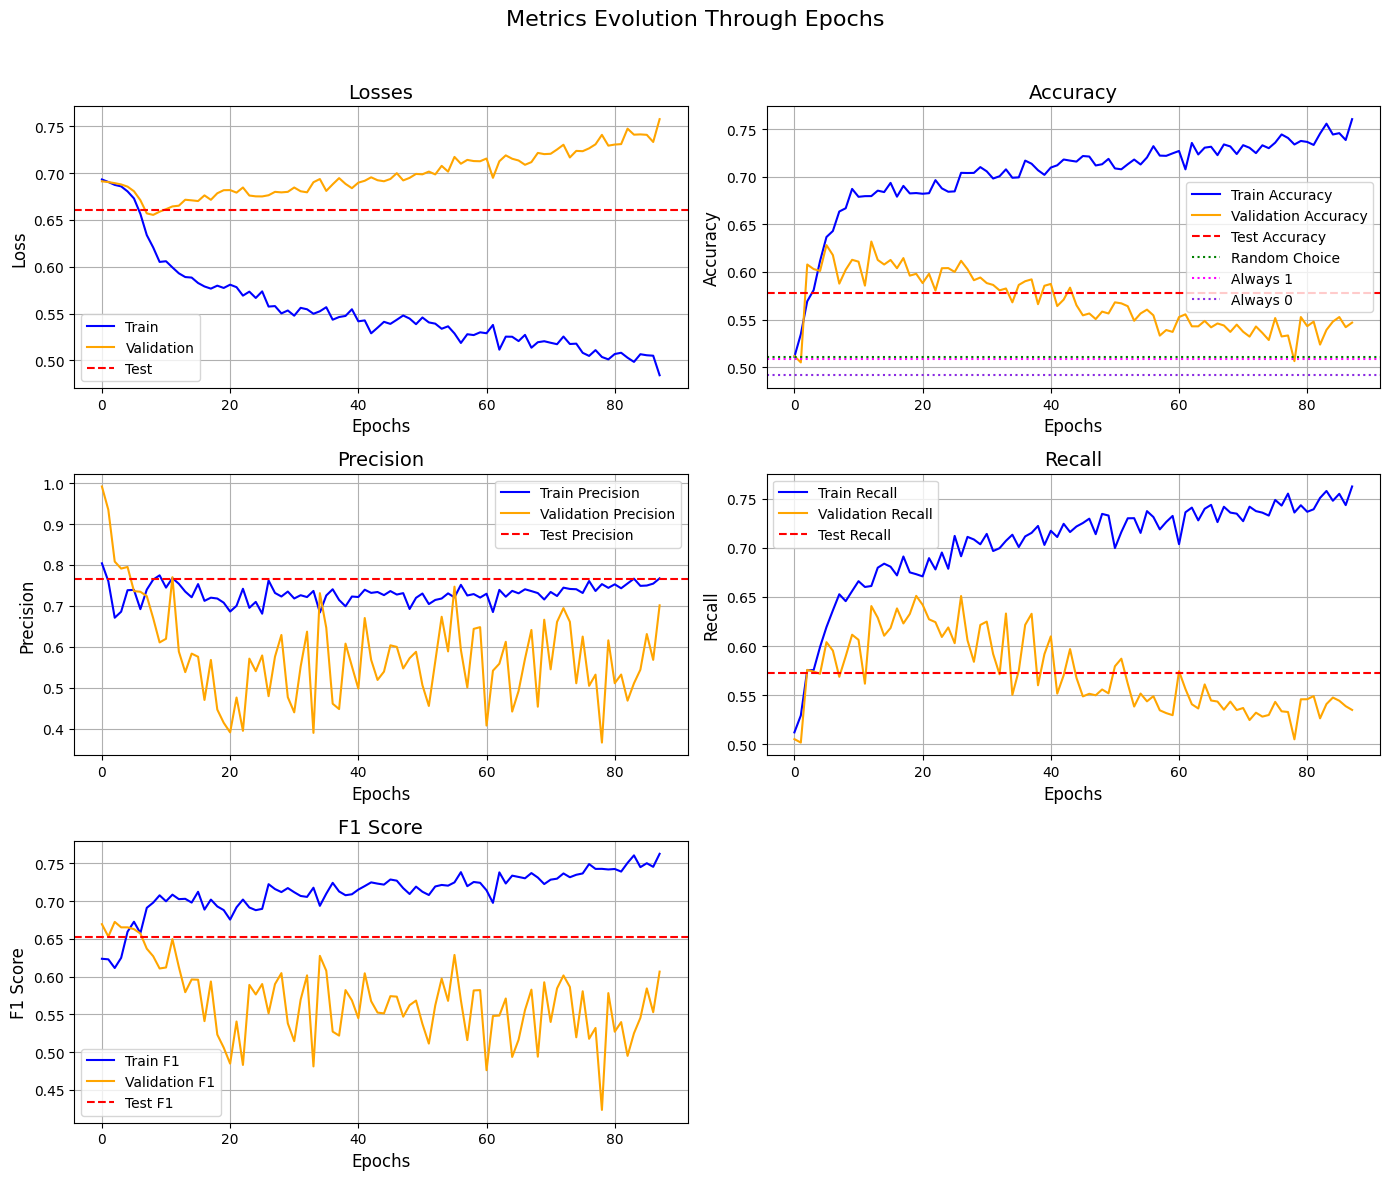

In [66]:
# Plot all the metrics evolution through the epochs

# Create a figure with 3 rows and 2 columns of subplots
fig, axis = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Metrics Evolution Through Epochs', fontsize=16)

# Plot the loss evolution
axis[0, 0].set_title("Losses", fontsize=14)
axis[0, 0].plot(train_metrics["train_losses"], label="Train", color='blue')
axis[0, 0].plot(valid_metrics["val_losses"], label="Validation", color='orange')
axis[0, 0].axhline(test_loss, linestyle='--', color='red', label='Test')
axis[0, 0].set_xlabel('Epochs', fontsize=12)
axis[0, 0].set_ylabel('Loss', fontsize=12)
axis[0, 0].legend()
axis[0, 0].grid(True)

# Plot the accuracy evolution
axis[0, 1].set_title("Accuracy", fontsize=14)
axis[0, 1].plot(train_metrics["train_acc"], label="Train Accuracy", color='blue')
axis[0, 1].plot(valid_metrics["val_acc"], label="Validation Accuracy", color='orange')
axis[0, 1].axhline(test_acc, linestyle='--', color='red', label='Test Accuracy')
# Add baseline accuracies
axis[0, 1].axhline(random_choice_accuracy, linestyle=':', color='green', label='Random Choice')
axis[0, 1].axhline(always_1_accuracy, linestyle=':', color='magenta', label='Always 1')
axis[0, 1].axhline(always_0_accuracy, linestyle=':', color='blueviolet', label='Always 0')
axis[0, 1].set_xlabel('Epochs', fontsize=12)
axis[0, 1].set_ylabel('Accuracy', fontsize=12)
axis[0, 1].legend()
axis[0, 1].grid(True)

# Plot the precision evolution
axis[1, 0].set_title("Precision", fontsize=14)
axis[1, 0].plot(train_metrics["train_precision"], label="Train Precision", color='blue')
axis[1, 0].plot(valid_metrics["val_precision"], label="Validation Precision", color='orange')
axis[1, 0].axhline(test_precision, linestyle='--', color='red', label='Test Precision')
axis[1, 0].set_xlabel('Epochs', fontsize=12)
axis[1, 0].set_ylabel('Precision', fontsize=12)
axis[1, 0].legend()
axis[1, 0].grid(True)

# Plot the recall evolution
axis[1, 1].set_title("Recall", fontsize=14)
axis[1, 1].plot(train_metrics["train_recall"], label="Train Recall", color='blue')
axis[1, 1].plot(valid_metrics["val_recall"], label="Validation Recall", color='orange')
axis[1, 1].axhline(test_recall, linestyle='--', color='red', label='Test Recall')
axis[1, 1].set_xlabel('Epochs', fontsize=12)
axis[1, 1].set_ylabel('Recall', fontsize=12)
axis[1, 1].legend()
axis[1, 1].grid(True)

# Plot the F1 score evolution
axis[2, 0].set_title("F1 Score", fontsize=14)
axis[2, 0].plot(train_metrics["train_f1"], label="Train F1", color='blue')
axis[2, 0].plot(valid_metrics["val_f1"], label="Validation F1", color='orange')
axis[2, 0].axhline(test_f1, linestyle='--', color='red', label='Test F1')
axis[2, 0].set_xlabel('Epochs', fontsize=12)
axis[2, 0].set_ylabel('F1 Score', fontsize=12)
axis[2, 0].legend()
axis[2, 0].grid(True)

# Hide the unused subplot
axis[2, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

# GRU model

In [59]:
# Create the hyperparameters for the GRU model
GRU_HP = HyperParametersClass(
    embedding_dim=embedding_dim,
    hidden_dim=64,
    gru_layers=2,
    gru_dropout=0.5,
    num_classes=2,
    padding_id=train_dataset.padding_id,
    device=DEVICE,
    bidirectional = True,
    word2vec_embeddings = word_embeddings
)

In [60]:
class GRUModel(nn.Module):
    # Define the GRU model
    def __init__(self, hparams) -> None:
        super().__init__()

        # Save the hyperparameters
        self.hparams = hparams

        # Create the embedding layer with pre-trained word2vec embeddings
        # The weights of the embedding layer are frozen
        self.embedding = nn.Embedding.from_pretrained(
            self.hparams.word2vec_embeddings,
            padding_idx=self.hparams.padding_id,
            freeze=True
        ).to(self.hparams.device)

        # Create the GRU layers
        self.gru = nn.GRU(
            input_size=self.hparams.embedding_dim,
            hidden_size=self.hparams.hidden_dim,
            num_layers=self.hparams.gru_layers,
            batch_first=True,
            dropout=self.hparams.gru_dropout,
            bidirectional=self.hparams.bidirectional,
            device=self.hparams.device
        )

        # Determine the output dimension of the GRU
        gru_output_dim = self.hparams.hidden_dim * 2 if self.hparams.bidirectional else self.hparams.hidden_dim

        # Create the dropout layer
        self.dropout = nn.Dropout(self.hparams.gru_dropout)

        # Create the projection layer for the classification
        self.projection = nn.Linear(
            in_features=gru_output_dim,
            out_features=self.hparams.num_classes,
            device=self.hparams.device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the sequence lengths and input IDs from the batch
        sequence_lengths, input_ids = batch

        # Embed the input tokens and apply dropout
        embeds = self.embedding(input_ids)
        embeds = self.dropout(embeds)

        # Pack the sequence for the GRU
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Pass the packed sequence through the GRU
        packed_output, hidden_state = self.gru(packed)

        # If bidirectional, concatenate the final forward and backward hidden states
        if self.hparams.bidirectional:
            hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        else:
            hidden = hidden_state[-1, :, :]

        # Apply dropout to the hidden state and project to the number of classes
        hidden = self.dropout(hidden)
        logits = self.projection(hidden)

        # Return the logits of each class
        return logits


# Training GRU

In [61]:
# Create the GRU model
irony_tagger_gru = GRUModel(GRU_HP)

In [62]:
# Create the Trainer for the GRU model
trainer_gru = Trainer(
    model=irony_tagger_gru,
    optimizer=torch.optim.Adam(irony_tagger_gru.parameters(), lr=0.00010),
)

In [63]:
# Train the GRU model
train_metrics_gru,valid_metrics_gru = trainer_gru.train(training_dataloader,
                                            validation_dataloader,
                                            epochs=250,
                                            early_stopper = 75,
                                            best_val_acc=True)

Training ...
####################################################################################################
 Epoch  1


Train Loss: 0.7471	Train accuracy: 0.3333	Train precision: 0.2500	Train recall: 0.2500	Train F1: 0.2500: 100%|██████████| 32/32 [00:00<00:00, 48.16it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.7     |   0.692    |
| Accuracy  |   0.496    |   0.505    |
| Precision |   0.429    |   0.913    |
|  Recall   |   0.504    |   0.502    |
|    F1     |   0.459    |   0.648    |
+-----------+------------+------------+

	[Epoch:  1] train loss = 0.6995 	 train accuracy = 0.4963
	[Epoch:  1] valid loss = 0.6920 	 valid accuracy = 0.5050

####################################################################################################
 Epoch  2


Train Loss: 0.6956	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 43.70it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.691    |    0.69    |
| Accuracy  |   0.529    |   0.501    |
| Precision |   0.578    |   0.926    |
|  Recall   |   0.533    |    0.5     |
|    F1     |   0.553    |   0.649    |
+-----------+------------+------------+

	[Epoch:  2] train loss = 0.6910 	 train accuracy = 0.5288
	[Epoch:  2] valid loss = 0.6901 	 valid accuracy = 0.5011

####################################################################################################
 Epoch  3


Train Loss: 0.7004	Train accuracy: 0.4444	Train precision: 0.5000	Train recall: 0.4000	Train F1: 0.4444: 100%|██████████| 32/32 [00:00<00:00, 45.79it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.688    |   0.688    |
| Accuracy  |   0.536    |   0.525    |
| Precision |   0.585    |   0.921    |
|  Recall   |   0.538    |   0.514    |
|    F1     |   0.559    |   0.659    |
+-----------+------------+------------+

	[Epoch:  3] train loss = 0.6881 	 train accuracy = 0.5356
	[Epoch:  3] valid loss = 0.6880 	 valid accuracy = 0.5254

####################################################################################################
 Epoch  4


Train Loss: 0.6365	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 47.69it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.678    |   0.686    |
| Accuracy  |   0.572    |   0.549    |
| Precision |    0.62    |   0.909    |
|  Recall   |   0.571    |   0.528    |
|    F1     |   0.593    |   0.668    |
+-----------+------------+------------+

	[Epoch:  4] train loss = 0.6783 	 train accuracy = 0.5718
	[Epoch:  4] valid loss = 0.6860 	 valid accuracy = 0.5487

####################################################################################################
 Epoch  5


Train Loss: 0.6634	Train accuracy: 0.6667	Train precision: 0.3333	Train recall: 0.5000	Train F1: 0.4000: 100%|██████████| 32/32 [00:00<00:00, 44.23it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.673    |   0.683    |
| Accuracy  |   0.592    |   0.573    |
| Precision |   0.619    |   0.847    |
|  Recall   |   0.589    |   0.547    |
|    F1     |   0.601    |   0.664    |
+-----------+------------+------------+

	[Epoch:  5] train loss = 0.6730 	 train accuracy = 0.5919
	[Epoch:  5] valid loss = 0.6831 	 valid accuracy = 0.5730

####################################################################################################
 Epoch  6


Train Loss: 0.6569	Train accuracy: 0.5556	Train precision: 0.8000	Train recall: 0.5714	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 43.92it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.665    |   0.682    |
| Accuracy  |   0.616    |   0.565    |
| Precision |   0.649    |   0.907    |
|  Recall   |    0.62    |   0.538    |
|    F1     |   0.631    |   0.675    |
+-----------+------------+------------+

	[Epoch:  6] train loss = 0.6646 	 train accuracy = 0.6162
	[Epoch:  6] valid loss = 0.6820 	 valid accuracy = 0.5652

####################################################################################################
 Epoch  7


Train Loss: 0.5948	Train accuracy: 0.7778	Train precision: 0.8333	Train recall: 0.8333	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 45.06it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.654    |   0.678    |
| Accuracy  |   0.639    |   0.584    |
| Precision |   0.725    |   0.864    |
|  Recall   |   0.627    |   0.553    |
|    F1     |    0.67    |   0.674    |
+-----------+------------+------------+

	[Epoch:  7] train loss = 0.6538 	 train accuracy = 0.6388
	[Epoch:  7] valid loss = 0.6784 	 valid accuracy = 0.5837

####################################################################################################
 Epoch  8


Train Loss: 0.6636	Train accuracy: 0.5556	Train precision: 0.2500	Train recall: 0.5000	Train F1: 0.3333: 100%|██████████| 32/32 [00:00<00:00, 47.59it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.648    |   0.676    |
| Accuracy  |   0.649    |   0.598    |
| Precision |   0.711    |   0.864    |
|  Recall   |   0.634    |   0.564    |
|    F1     |   0.667    |   0.682    |
+-----------+------------+------------+

	[Epoch:  8] train loss = 0.6480 	 train accuracy = 0.6492
	[Epoch:  8] valid loss = 0.6757 	 valid accuracy = 0.5983

####################################################################################################
 Epoch  9


Train Loss: 0.6740	Train accuracy: 0.5556	Train precision: 0.6000	Train recall: 0.6000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 46.25it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.634    |   0.671    |
| Accuracy  |   0.657    |   0.601    |
| Precision |   0.728    |   0.803    |
|  Recall   |   0.645    |   0.572    |
|    F1     |   0.682    |   0.668    |
+-----------+------------+------------+

	[Epoch:  9] train loss = 0.6339 	 train accuracy = 0.6570
	[Epoch:  9] valid loss = 0.6714 	 valid accuracy = 0.6013

####################################################################################################
 Epoch 10


Train Loss: 0.4662	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 41.12it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.619    |   0.673    |
| Accuracy  |   0.675    |   0.588    |
| Precision |   0.737    |   0.829    |
|  Recall   |   0.661    |   0.559    |
|    F1     |   0.696    |   0.668    |
+-----------+------------+------------+

	[Epoch: 10] train loss = 0.6189 	 train accuracy = 0.6755
	[Epoch: 10] valid loss = 0.6731 	 valid accuracy = 0.5885

####################################################################################################
 Epoch 11


Train Loss: 0.5626	Train accuracy: 0.8889	Train precision: 0.8571	Train recall: 1.0000	Train F1: 0.9231: 100%|██████████| 32/32 [00:00<00:00, 35.24it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.613    |   0.668    |
| Accuracy  |   0.681    |   0.618    |
| Precision |   0.731    |   0.721    |
|  Recall   |   0.674    |   0.596    |
|    F1     |   0.699    |   0.652    |
+-----------+------------+------------+

	[Epoch: 11] train loss = 0.6129 	 train accuracy = 0.6806
	[Epoch: 11] valid loss = 0.6680 	 valid accuracy = 0.6178

####################################################################################################
 Epoch 12


Train Loss: 0.5428	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 33.69it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.601    |    0.67    |
| Accuracy  |   0.675    |   0.622    |
| Precision |   0.742    |   0.667    |
|  Recall   |   0.659    |   0.611    |
|    F1     |   0.695    |   0.637    |
+-----------+------------+------------+

	[Epoch: 12] train loss = 0.6008 	 train accuracy = 0.6751
	[Epoch: 12] valid loss = 0.6702 	 valid accuracy = 0.6217

####################################################################################################
 Epoch 13


Train Loss: 0.7520	Train accuracy: 0.2222	Train precision: 0.5000	Train recall: 0.2857	Train F1: 0.3636: 100%|██████████| 32/32 [00:00<00:00, 32.64it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.606    |   0.682    |
| Accuracy  |   0.661    |   0.568    |
| Precision |   0.706    |   0.378    |
|  Recall   |   0.657    |   0.606    |
|    F1     |   0.677    |   0.464    |
+-----------+------------+------------+

	[Epoch: 13] train loss = 0.6065 	 train accuracy = 0.6608
	[Epoch: 13] valid loss = 0.6820 	 valid accuracy = 0.5681

####################################################################################################
 Epoch 14


Train Loss: 0.5665	Train accuracy: 0.5556	Train precision: 0.7500	Train recall: 0.5000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 34.08it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.596    |   0.675    |
| Accuracy  |   0.675    |   0.608    |
| Precision |   0.709    |    0.55    |
|  Recall   |   0.673    |   0.621    |
|    F1     |   0.684    |   0.582    |
+-----------+------------+------------+

	[Epoch: 14] train loss = 0.5962 	 train accuracy = 0.6748
	[Epoch: 14] valid loss = 0.6752 	 valid accuracy = 0.6080

####################################################################################################
 Epoch 15


Train Loss: 0.5237	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.5000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 44.95it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.59    |   0.675    |
| Accuracy  |   0.684    |   0.616    |
| Precision |   0.696    |   0.586    |
|  Recall   |   0.684    |   0.624    |
|    F1     |   0.686    |   0.603    |
+-----------+------------+------------+

	[Epoch: 15] train loss = 0.5900 	 train accuracy = 0.6839
	[Epoch: 15] valid loss = 0.6750 	 valid accuracy = 0.6158

####################################################################################################
 Epoch 16


Train Loss: 0.5421	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 44.67it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.588    |   0.674    |
| Accuracy  |   0.687    |   0.628    |
| Precision |   0.699    |   0.655    |
|  Recall   |   0.691    |   0.621    |
|    F1     |   0.692    |   0.637    |
+-----------+------------+------------+

	[Epoch: 16] train loss = 0.5883 	 train accuracy = 0.6874
	[Epoch: 16] valid loss = 0.6742 	 valid accuracy = 0.6285

####################################################################################################
 Epoch 17


Train Loss: 0.6372	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.4000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 47.33it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.588    |   0.676    |
| Accuracy  |   0.686    |   0.631    |
| Precision |   0.711    |   0.655    |
|  Recall   |    0.68    |   0.624    |
|    F1     |    0.69    |   0.639    |
+-----------+------------+------------+

	[Epoch: 17] train loss = 0.5880 	 train accuracy = 0.6864
	[Epoch: 17] valid loss = 0.6763 	 valid accuracy = 0.6313

####################################################################################################
 Epoch 18


Train Loss: 1.0052	Train accuracy: 0.2222	Train precision: 0.4000	Train recall: 0.3333	Train F1: 0.3636: 100%|██████████| 32/32 [00:00<00:00, 45.39it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.601    |   0.676    |
| Accuracy  |   0.665    |   0.608    |
| Precision |   0.673    |   0.671    |
|  Recall   |   0.675    |   0.595    |
|    F1     |   0.671    |    0.63    |
+-----------+------------+------------+

	[Epoch: 18] train loss = 0.6012 	 train accuracy = 0.6649
	[Epoch: 18] valid loss = 0.6762 	 valid accuracy = 0.6080

####################################################################################################
 Epoch 19


Train Loss: 0.7805	Train accuracy: 0.4444	Train precision: 0.3333	Train recall: 0.6667	Train F1: 0.4444: 100%|██████████| 32/32 [00:00<00:00, 44.89it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.586    |   0.676    |
| Accuracy  |   0.679    |   0.623    |
| Precision |   0.694    |   0.611    |
|  Recall   |   0.686    |   0.625    |
|    F1     |   0.687    |   0.617    |
+-----------+------------+------------+

	[Epoch: 19] train loss = 0.5861 	 train accuracy = 0.6792
	[Epoch: 19] valid loss = 0.6764 	 valid accuracy = 0.6235

####################################################################################################
 Epoch 20


Train Loss: 0.6344	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 45.18it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.586    |   0.678    |
| Accuracy  |   0.681    |   0.614    |
| Precision |   0.695    |   0.571    |
|  Recall   |   0.682    |   0.621    |
|    F1     |   0.687    |   0.594    |
+-----------+------------+------------+

	[Epoch: 20] train loss = 0.5864 	 train accuracy = 0.6812
	[Epoch: 20] valid loss = 0.6781 	 valid accuracy = 0.6137

####################################################################################################
 Epoch 21


Train Loss: 0.3593	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 47.12it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.579    |   0.678    |
| Accuracy  |   0.692    |   0.616    |
| Precision |    0.71    |   0.595    |
|  Recall   |   0.694    |   0.618    |
|    F1     |   0.699    |   0.606    |
+-----------+------------+------------+

	[Epoch: 21] train loss = 0.5793 	 train accuracy = 0.6921
	[Epoch: 21] valid loss = 0.6780 	 valid accuracy = 0.6157

####################################################################################################
 Epoch 22


Train Loss: 0.4308	Train accuracy: 0.8889	Train precision: 0.5000	Train recall: 1.0000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.43it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.578    |    0.68    |
| Accuracy  |   0.687    |   0.614    |
| Precision |   0.706    |   0.543    |
|  Recall   |   0.689    |   0.629    |
|    F1     |   0.692    |   0.581    |
+-----------+------------+------------+

	[Epoch: 22] train loss = 0.5778 	 train accuracy = 0.6867
	[Epoch: 22] valid loss = 0.6798 	 valid accuracy = 0.6137

####################################################################################################
 Epoch 23


Train Loss: 0.6321	Train accuracy: 0.6667	Train precision: 0.0000	Train recall: 0.0000	Train F1: 0.0000: 100%|██████████| 32/32 [00:00<00:00, 44.73it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.584    |   0.677    |
| Accuracy  |   0.681    |   0.619    |
| Precision |   0.667    |    0.6     |
|  Recall   |   0.669    |    0.62    |
|    F1     |   0.663    |   0.609    |
+-----------+------------+------------+

	[Epoch: 23] train loss = 0.5844 	 train accuracy = 0.6805
	[Epoch: 23] valid loss = 0.6773 	 valid accuracy = 0.6185

####################################################################################################
 Epoch 24


Train Loss: 0.7687	Train accuracy: 0.5556	Train precision: 0.6667	Train recall: 0.6667	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.09it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.584    |   0.678    |
| Accuracy  |   0.674    |   0.616    |
| Precision |   0.671    |   0.555    |
|  Recall   |   0.689    |   0.628    |
|    F1     |   0.677    |   0.588    |
+-----------+------------+------------+

	[Epoch: 24] train loss = 0.5845 	 train accuracy = 0.6736
	[Epoch: 24] valid loss = 0.6780 	 valid accuracy = 0.6157

####################################################################################################
 Epoch 25


Train Loss: 0.6852	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.7143	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 46.38it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.577    |   0.679    |
| Accuracy  |   0.701    |   0.603    |
| Precision |   0.715    |   0.686    |
|  Recall   |   0.701    |   0.587    |
|    F1     |   0.706    |   0.632    |
+-----------+------------+------------+

	[Epoch: 25] train loss = 0.5766 	 train accuracy = 0.7011
	[Epoch: 25] valid loss = 0.6790 	 valid accuracy = 0.6031

####################################################################################################
 Epoch 26


Train Loss: 0.5188	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.7143	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 46.76it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.574    |   0.682    |
| Accuracy  |   0.687    |   0.605    |
| Precision |    0.71    |   0.509    |
|  Recall   |   0.687    |   0.627    |
|    F1     |   0.695    |   0.561    |
+-----------+------------+------------+

	[Epoch: 26] train loss = 0.5739 	 train accuracy = 0.6867
	[Epoch: 26] valid loss = 0.6825 	 valid accuracy = 0.6050

####################################################################################################
 Epoch 27


Train Loss: 0.3336	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 43.41it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.57    |   0.678    |
| Accuracy  |   0.701    |   0.609    |
| Precision |    0.7     |   0.571    |
|  Recall   |   0.709    |   0.615    |
|    F1     |   0.703    |   0.591    |
+-----------+------------+------------+

	[Epoch: 27] train loss = 0.5696 	 train accuracy = 0.7012
	[Epoch: 27] valid loss = 0.6778 	 valid accuracy = 0.6089

####################################################################################################
 Epoch 28


Train Loss: 0.5923	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8333	Train F1: 0.9091: 100%|██████████| 32/32 [00:00<00:00, 35.12it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.574    |    0.68    |
| Accuracy  |   0.703    |   0.607    |
| Precision |   0.724    |   0.524    |
|  Recall   |   0.704    |   0.624    |
|    F1     |   0.711    |   0.569    |
+-----------+------------+------------+

	[Epoch: 28] train loss = 0.5738 	 train accuracy = 0.7033
	[Epoch: 28] valid loss = 0.6800 	 valid accuracy = 0.6070

####################################################################################################
 Epoch 29


Train Loss: 0.5935	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.8000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 33.22it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.571    |   0.678    |
| Accuracy  |   0.691    |    0.61    |
| Precision |   0.693    |   0.634    |
|  Recall   |   0.702    |   0.602    |
|    F1     |   0.695    |   0.617    |
+-----------+------------+------------+

	[Epoch: 29] train loss = 0.5714 	 train accuracy = 0.6908
	[Epoch: 29] valid loss = 0.6778 	 valid accuracy = 0.6098

####################################################################################################
 Epoch 30


Train Loss: 0.5901	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 32.43it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.57    |   0.678    |
| Accuracy  |   0.698    |   0.619    |
| Precision |   0.713    |    0.63    |
|  Recall   |   0.698    |   0.613    |
|    F1     |   0.703    |   0.621    |
+-----------+------------+------------+

	[Epoch: 30] train loss = 0.5695 	 train accuracy = 0.6976
	[Epoch: 30] valid loss = 0.6784 	 valid accuracy = 0.6185

####################################################################################################
 Epoch 31


Train Loss: 0.6216	Train accuracy: 0.5556	Train precision: 0.6000	Train recall: 0.6000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 33.84it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.568    |   0.681    |
| Accuracy  |   0.691    |   0.619    |
| Precision |   0.696    |   0.622    |
|  Recall   |   0.699    |   0.615    |
|    F1     |   0.695    |   0.617    |
+-----------+------------+------------+

	[Epoch: 31] train loss = 0.5685 	 train accuracy = 0.6909
	[Epoch: 31] valid loss = 0.6807 	 valid accuracy = 0.6185

####################################################################################################
 Epoch 32


Train Loss: 0.4851	Train accuracy: 0.7778	Train precision: 0.8000	Train recall: 0.8000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 39.20it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.565    |   0.681    |
| Accuracy  |   0.695    |   0.617    |
| Precision |   0.701    |   0.609    |
|  Recall   |   0.699    |   0.614    |
|    F1     |   0.698    |    0.61    |
+-----------+------------+------------+

	[Epoch: 32] train loss = 0.5648 	 train accuracy = 0.6947
	[Epoch: 32] valid loss = 0.6812 	 valid accuracy = 0.6166

####################################################################################################
 Epoch 33


Train Loss: 0.4532	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 0.7500	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 44.41it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.56    |   0.685    |
| Accuracy  |   0.699    |   0.612    |
| Precision |   0.723    |   0.505    |
|  Recall   |   0.697    |   0.639    |
|    F1     |   0.708    |   0.563    |
+-----------+------------+------------+

	[Epoch: 33] train loss = 0.5602 	 train accuracy = 0.6991
	[Epoch: 33] valid loss = 0.6848 	 valid accuracy = 0.6118

####################################################################################################
 Epoch 34


Train Loss: 0.6458	Train accuracy: 0.6667	Train precision: 0.7143	Train recall: 0.8333	Train F1: 0.7692: 100%|██████████| 32/32 [00:00<00:00, 45.23it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.572    |   0.682    |
| Accuracy  |   0.697    |   0.606    |
| Precision |   0.694    |   0.608    |
|  Recall   |   0.712    |   0.602    |
|    F1     |   0.701    |   0.605    |
+-----------+------------+------------+

	[Epoch: 34] train loss = 0.5723 	 train accuracy = 0.6971
	[Epoch: 34] valid loss = 0.6818 	 valid accuracy = 0.6059

####################################################################################################
 Epoch 35


Train Loss: 0.6957	Train accuracy: 0.6667	Train precision: 0.6000	Train recall: 0.7500	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 47.42it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.565    |   0.681    |
| Accuracy  |   0.704    |   0.599    |
| Precision |   0.713    |   0.563    |
|  Recall   |   0.709    |   0.604    |
|    F1     |   0.709    |   0.582    |
+-----------+------------+------------+

	[Epoch: 35] train loss = 0.5651 	 train accuracy = 0.7042
	[Epoch: 35] valid loss = 0.6812 	 valid accuracy = 0.5992

####################################################################################################
 Epoch 36


Train Loss: 0.6315	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.5000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 44.32it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.56    |   0.682    |
| Accuracy  |   0.699    |   0.605    |
| Precision |   0.699    |   0.579    |
|  Recall   |   0.706    |   0.609    |
|    F1     |    0.7     |   0.593    |
+-----------+------------+------------+

	[Epoch: 36] train loss = 0.5602 	 train accuracy = 0.6995
	[Epoch: 36] valid loss = 0.6824 	 valid accuracy = 0.6050

####################################################################################################
 Epoch 37


Train Loss: 0.6499	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 1.0000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 44.80it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.563    |   0.683    |
| Accuracy  |   0.701    |   0.598    |
| Precision |    0.7     |   0.593    |
|  Recall   |   0.719    |   0.596    |
|    F1     |   0.706    |   0.593    |
+-----------+------------+------------+

	[Epoch: 37] train loss = 0.5630 	 train accuracy = 0.7008
	[Epoch: 37] valid loss = 0.6826 	 valid accuracy = 0.5981

####################################################################################################
 Epoch 38


Train Loss: 0.6137	Train accuracy: 0.5556	Train precision: 0.6667	Train recall: 0.4000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 43.96it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.571    |   0.682    |
| Accuracy  |   0.699    |   0.601    |
| Precision |   0.728    |   0.618    |
|  Recall   |   0.695    |   0.594    |
|    F1     |   0.707    |   0.605    |
+-----------+------------+------------+

	[Epoch: 38] train loss = 0.5709 	 train accuracy = 0.6995
	[Epoch: 38] valid loss = 0.6824 	 valid accuracy = 0.6010

####################################################################################################
 Epoch 39


Train Loss: 0.5416	Train accuracy: 0.5556	Train precision: 0.5714	Train recall: 0.8000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 46.87it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.56    |   0.685    |
| Accuracy  |   0.697    |   0.604    |
| Precision |   0.687    |   0.704    |
|  Recall   |   0.717    |   0.583    |
|    F1     |   0.699    |   0.638    |
+-----------+------------+------------+

	[Epoch: 39] train loss = 0.5599 	 train accuracy = 0.6968
	[Epoch: 39] valid loss = 0.6854 	 valid accuracy = 0.6038

####################################################################################################
 Epoch 40


Train Loss: 0.3841	Train accuracy: 0.8889	Train precision: 0.8333	Train recall: 1.0000	Train F1: 0.9091: 100%|██████████| 32/32 [00:00<00:00, 46.33it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |   0.684    |
| Accuracy  |   0.719    |   0.609    |
| Precision |   0.737    |   0.638    |
|  Recall   |   0.722    |    0.6     |
|    F1     |   0.727    |   0.618    |
+-----------+------------+------------+

	[Epoch: 40] train loss = 0.5428 	 train accuracy = 0.7187
	[Epoch: 40] valid loss = 0.6841 	 valid accuracy = 0.6088

####################################################################################################
 Epoch 41


Train Loss: 0.3936	Train accuracy: 0.8889	Train precision: 0.7500	Train recall: 1.0000	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 45.13it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.554    |   0.686    |
| Accuracy  |   0.712    |   0.602    |
| Precision |   0.715    |   0.592    |
|  Recall   |    0.72    |   0.601    |
|    F1     |   0.715    |   0.596    |
+-----------+------------+------------+

	[Epoch: 41] train loss = 0.5535 	 train accuracy = 0.7123
	[Epoch: 41] valid loss = 0.6862 	 valid accuracy = 0.6020

####################################################################################################
 Epoch 42


Train Loss: 0.8966	Train accuracy: 0.2222	Train precision: 0.5000	Train recall: 0.2857	Train F1: 0.3636: 100%|██████████| 32/32 [00:00<00:00, 42.66it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.565    |   0.689    |
| Accuracy  |   0.702    |   0.611    |
| Precision |    0.71    |   0.559    |
|  Recall   |   0.711    |    0.62    |
|    F1     |   0.709    |   0.587    |
+-----------+------------+------------+

	[Epoch: 42] train loss = 0.5647 	 train accuracy = 0.7018
	[Epoch: 42] valid loss = 0.6889 	 valid accuracy = 0.6107

####################################################################################################
 Epoch 43


Train Loss: 0.6792	Train accuracy: 0.6667	Train precision: 0.6667	Train recall: 0.5000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 44.82it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.552    |   0.689    |
| Accuracy  |   0.709    |   0.605    |
| Precision |   0.706    |   0.528    |
|  Recall   |   0.715    |   0.619    |
|    F1     |   0.708    |   0.568    |
+-----------+------------+------------+

	[Epoch: 43] train loss = 0.5525 	 train accuracy = 0.7088
	[Epoch: 43] valid loss = 0.6886 	 valid accuracy = 0.6049

####################################################################################################
 Epoch 44


Train Loss: 0.6593	Train accuracy: 0.5556	Train precision: 0.5000	Train recall: 0.7500	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 48.40it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.554    |   0.686    |
| Accuracy  |   0.702    |   0.604    |
| Precision |   0.688    |   0.613    |
|  Recall   |   0.722    |    0.6     |
|    F1     |   0.702    |   0.606    |
+-----------+------------+------------+

	[Epoch: 44] train loss = 0.5537 	 train accuracy = 0.7022
	[Epoch: 44] valid loss = 0.6856 	 valid accuracy = 0.6040

####################################################################################################
 Epoch 45


Train Loss: 0.4619	Train accuracy: 0.7778	Train precision: 0.8571	Train recall: 0.8571	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 35.36it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.555    |   0.684    |
| Accuracy  |   0.703    |    0.61    |
| Precision |   0.704    |   0.593    |
|  Recall   |   0.714    |   0.612    |
|    F1     |   0.706    |   0.601    |
+-----------+------------+------------+

	[Epoch: 45] train loss = 0.5546 	 train accuracy = 0.7030
	[Epoch: 45] valid loss = 0.6841 	 valid accuracy = 0.6098

####################################################################################################
 Epoch 46


Train Loss: 0.5870	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.6250	Train F1: 0.7692: 100%|██████████| 32/32 [00:01<00:00, 18.87it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.556    |   0.684    |
| Accuracy  |   0.703    |    0.61    |
| Precision |   0.717    |   0.601    |
|  Recall   |   0.708    |    0.61    |
|    F1     |   0.708    |   0.604    |
+-----------+------------+------------+

	[Epoch: 46] train loss = 0.5559 	 train accuracy = 0.7027
	[Epoch: 46] valid loss = 0.6839 	 valid accuracy = 0.6098

####################################################################################################
 Epoch 47


Train Loss: 0.8819	Train accuracy: 0.3333	Train precision: 1.0000	Train recall: 0.2500	Train F1: 0.4000: 100%|██████████| 32/32 [00:01<00:00, 20.22it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.56    |   0.685    |
| Accuracy  |   0.699    |   0.612    |
| Precision |   0.716    |   0.605    |
|  Recall   |   0.704    |   0.612    |
|    F1     |   0.701    |   0.607    |
+-----------+------------+------------+

	[Epoch: 47] train loss = 0.5600 	 train accuracy = 0.6989
	[Epoch: 47] valid loss = 0.6851 	 valid accuracy = 0.6118

####################################################################################################
 Epoch 48


Train Loss: 0.4909	Train accuracy: 0.6667	Train precision: 1.0000	Train recall: 0.5000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 40.11it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.542    |   0.685    |
| Accuracy  |   0.712    |   0.602    |
| Precision |   0.712    |   0.538    |
|  Recall   |    0.72    |   0.614    |
|    F1     |    0.71    |   0.573    |
+-----------+------------+------------+

	[Epoch: 48] train loss = 0.5419 	 train accuracy = 0.7118
	[Epoch: 48] valid loss = 0.6849 	 valid accuracy = 0.6020

####################################################################################################
 Epoch 49


Train Loss: 0.8618	Train accuracy: 0.4444	Train precision: 0.6000	Train recall: 0.5000	Train F1: 0.5455: 100%|██████████| 32/32 [00:00<00:00, 46.27it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.559    |   0.687    |
| Accuracy  |   0.698    |   0.615    |
| Precision |   0.699    |   0.585    |
|  Recall   |   0.711    |   0.619    |
|    F1     |    0.7     |    0.6     |
+-----------+------------+------------+

	[Epoch: 49] train loss = 0.5589 	 train accuracy = 0.6980
	[Epoch: 49] valid loss = 0.6867 	 valid accuracy = 0.6146

####################################################################################################
 Epoch 50


Train Loss: 0.6019	Train accuracy: 0.5556	Train precision: 0.5714	Train recall: 0.8000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 44.18it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.544    |   0.686    |
| Accuracy  |   0.711    |    0.6     |
| Precision |   0.688    |   0.601    |
|  Recall   |   0.736    |   0.597    |
|    F1     |   0.709    |   0.598    |
+-----------+------------+------------+

	[Epoch: 50] train loss = 0.5441 	 train accuracy = 0.7110
	[Epoch: 50] valid loss = 0.6859 	 valid accuracy = 0.6001

####################################################################################################
 Epoch 51


Train Loss: 0.7099	Train accuracy: 0.7778	Train precision: 0.8000	Train recall: 0.8000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 44.13it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.554    |    0.69    |
| Accuracy  |   0.704    |   0.579    |
| Precision |    0.71    |   0.677    |
|  Recall   |   0.714    |   0.564    |
|    F1     |   0.708    |   0.615    |
+-----------+------------+------------+

	[Epoch: 51] train loss = 0.5543 	 train accuracy = 0.7045
	[Epoch: 51] valid loss = 0.6899 	 valid accuracy = 0.5786

####################################################################################################
 Epoch 52


Train Loss: 0.5204	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 0.7500	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 43.33it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |   0.693    |
| Accuracy  |   0.717    |   0.606    |
| Precision |   0.737    |    0.51    |
|  Recall   |   0.715    |   0.629    |
|    F1     |   0.725    |   0.561    |
+-----------+------------+------------+

	[Epoch: 52] train loss = 0.5427 	 train accuracy = 0.7169
	[Epoch: 52] valid loss = 0.6930 	 valid accuracy = 0.6059

####################################################################################################
 Epoch 53


Train Loss: 0.4865	Train accuracy: 0.8889	Train precision: 0.6667	Train recall: 1.0000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 47.03it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.543    |    0.69    |
| Accuracy  |   0.723    |   0.603    |
| Precision |   0.715    |   0.549    |
|  Recall   |   0.736    |   0.611    |
|    F1     |   0.722    |   0.576    |
+-----------+------------+------------+

	[Epoch: 53] train loss = 0.5432 	 train accuracy = 0.7233
	[Epoch: 53] valid loss = 0.6904 	 valid accuracy = 0.6029

####################################################################################################
 Epoch 54


Train Loss: 0.3379	Train accuracy: 0.7778	Train precision: 0.6667	Train recall: 1.0000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 44.94it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.533    |   0.692    |
| Accuracy  |   0.722    |   0.611    |
| Precision |   0.706    |   0.589    |
|  Recall   |    0.74    |   0.613    |
|    F1     |    0.72    |   0.599    |
+-----------+------------+------------+

	[Epoch: 54] train loss = 0.5326 	 train accuracy = 0.7216
	[Epoch: 54] valid loss = 0.6916 	 valid accuracy = 0.6107

####################################################################################################
 Epoch 55


Train Loss: 0.3660	Train accuracy: 0.8889	Train precision: 0.5000	Train recall: 1.0000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 44.10it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.541    |   0.694    |
| Accuracy  |   0.717    |   0.609    |
| Precision |   0.719    |    0.54    |
|  Recall   |   0.723    |   0.623    |
|    F1     |   0.717    |   0.577    |
+-----------+------------+------------+

	[Epoch: 55] train loss = 0.5407 	 train accuracy = 0.7172
	[Epoch: 55] valid loss = 0.6939 	 valid accuracy = 0.6088

####################################################################################################
 Epoch 56


Train Loss: 0.6197	Train accuracy: 0.6667	Train precision: 0.5000	Train recall: 0.3333	Train F1: 0.4000: 100%|██████████| 32/32 [00:00<00:00, 44.11it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.535    |   0.695    |
| Accuracy  |   0.721    |   0.599    |
| Precision |   0.712    |   0.549    |
|  Recall   |    0.72    |   0.605    |
|    F1     |   0.713    |   0.574    |
+-----------+------------+------------+

	[Epoch: 56] train loss = 0.5348 	 train accuracy = 0.7208
	[Epoch: 56] valid loss = 0.6949 	 valid accuracy = 0.5990

####################################################################################################
 Epoch 57


Train Loss: 0.5622	Train accuracy: 0.6667	Train precision: 0.8333	Train recall: 0.7143	Train F1: 0.7692: 100%|██████████| 32/32 [00:00<00:00, 44.84it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.542    |   0.695    |
| Accuracy  |   0.711    |   0.599    |
| Precision |   0.711    |   0.549    |
|  Recall   |   0.723    |   0.605    |
|    F1     |   0.714    |   0.574    |
+-----------+------------+------------+

	[Epoch: 57] train loss = 0.5416 	 train accuracy = 0.7105
	[Epoch: 57] valid loss = 0.6949 	 valid accuracy = 0.5990

####################################################################################################
 Epoch 58


Train Loss: 0.3705	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 46.83it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.525    |   0.698    |
| Accuracy  |   0.729    |   0.603    |
| Precision |   0.723    |   0.524    |
|  Recall   |   0.739    |   0.619    |
|    F1     |   0.728    |   0.565    |
+-----------+------------+------------+

	[Epoch: 58] train loss = 0.5253 	 train accuracy = 0.7294
	[Epoch: 58] valid loss = 0.6978 	 valid accuracy = 0.6029

####################################################################################################
 Epoch 59


Train Loss: 0.6345	Train accuracy: 0.6667	Train precision: 0.4000	Train recall: 1.0000	Train F1: 0.5714: 100%|██████████| 32/32 [00:00<00:00, 43.93it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.535    |   0.697    |
| Accuracy  |   0.718    |   0.597    |
| Precision |   0.711    |   0.549    |
|  Recall   |   0.737    |   0.603    |
|    F1     |   0.718    |   0.573    |
+-----------+------------+------------+

	[Epoch: 59] train loss = 0.5351 	 train accuracy = 0.7181
	[Epoch: 59] valid loss = 0.6969 	 valid accuracy = 0.5971

####################################################################################################
 Epoch 60


Train Loss: 0.4680	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.7143	Train F1: 0.8333: 100%|██████████| 32/32 [00:00<00:00, 44.44it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.534    |   0.693    |
| Accuracy  |   0.723    |   0.605    |
| Precision |   0.729    |   0.593    |
|  Recall   |   0.729    |   0.604    |
|    F1     |   0.726    |   0.597    |
+-----------+------------+------------+

	[Epoch: 60] train loss = 0.5338 	 train accuracy = 0.7225
	[Epoch: 60] valid loss = 0.6928 	 valid accuracy = 0.6049

####################################################################################################
 Epoch 61


Train Loss: 0.5558	Train accuracy: 0.5556	Train precision: 0.6000	Train recall: 0.6000	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 33.73it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.529    |   0.703    |
| Accuracy  |   0.719    |   0.576    |
| Precision |   0.715    |   0.437    |
|  Recall   |   0.729    |   0.602    |
|    F1     |   0.721    |   0.504    |
+-----------+------------+------------+

	[Epoch: 61] train loss = 0.5286 	 train accuracy = 0.7185
	[Epoch: 61] valid loss = 0.7034 	 valid accuracy = 0.5757

####################################################################################################
 Epoch 62


Train Loss: 0.3004	Train accuracy: 0.8889	Train precision: 0.8000	Train recall: 1.0000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 33.07it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.528    |    0.7     |
| Accuracy  |   0.724    |    0.58    |
| Precision |   0.712    |   0.474    |
|  Recall   |   0.739    |    0.6     |
|    F1     |   0.723    |   0.527    |
+-----------+------------+------------+

	[Epoch: 62] train loss = 0.5276 	 train accuracy = 0.7236
	[Epoch: 62] valid loss = 0.6998 	 valid accuracy = 0.5796

####################################################################################################
 Epoch 63


Train Loss: 0.2733	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 32.32it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.53    |   0.697    |
| Accuracy  |    0.73    |   0.587    |
| Precision |   0.718    |   0.653    |
|  Recall   |   0.743    |   0.575    |
|    F1     |   0.728    |   0.611    |
+-----------+------------+------------+

	[Epoch: 63] train loss = 0.5296 	 train accuracy = 0.7305
	[Epoch: 63] valid loss = 0.6968 	 valid accuracy = 0.5874

####################################################################################################
 Epoch 64


Train Loss: 0.7034	Train accuracy: 0.4444	Train precision: 0.6000	Train recall: 0.5000	Train F1: 0.5455: 100%|██████████| 32/32 [00:01<00:00, 31.35it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.536    |   0.695    |
| Accuracy  |   0.714    |   0.584    |
| Precision |   0.723    |   0.633    |
|  Recall   |   0.721    |   0.573    |
|    F1     |   0.719    |   0.601    |
+-----------+------------+------------+

	[Epoch: 64] train loss = 0.5357 	 train accuracy = 0.7138
	[Epoch: 64] valid loss = 0.6951 	 valid accuracy = 0.5835

####################################################################################################
 Epoch 65


Train Loss: 0.6240	Train accuracy: 0.5556	Train precision: 0.4000	Train recall: 0.6667	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 43.70it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.533    |   0.698    |
| Accuracy  |   0.722    |   0.584    |
| Precision |   0.716    |   0.645    |
|  Recall   |   0.734    |   0.572    |
|    F1     |   0.722    |   0.606    |
+-----------+------------+------------+

	[Epoch: 65] train loss = 0.5334 	 train accuracy = 0.7217
	[Epoch: 65] valid loss = 0.6979 	 valid accuracy = 0.5835

####################################################################################################
 Epoch 66


Train Loss: 0.8807	Train accuracy: 0.4444	Train precision: 0.6000	Train recall: 0.5000	Train F1: 0.5455: 100%|██████████| 32/32 [00:00<00:00, 43.22it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.541    |   0.697    |
| Accuracy  |   0.719    |   0.601    |
| Precision |   0.732    |   0.573    |
|  Recall   |   0.725    |   0.603    |
|    F1     |   0.725    |   0.586    |
+-----------+------------+------------+

	[Epoch: 66] train loss = 0.5414 	 train accuracy = 0.7190
	[Epoch: 66] valid loss = 0.6968 	 valid accuracy = 0.6010

####################################################################################################
 Epoch 67


Train Loss: 0.7784	Train accuracy: 0.4444	Train precision: 0.5000	Train recall: 0.4000	Train F1: 0.4444: 100%|██████████| 32/32 [00:00<00:00, 47.19it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.531    |   0.699    |
| Accuracy  |   0.722    |   0.583    |
| Precision |    0.7     |   0.573    |
|  Recall   |   0.739    |    0.58    |
|    F1     |   0.717    |   0.576    |
+-----------+------------+------------+

	[Epoch: 67] train loss = 0.5307 	 train accuracy = 0.7221
	[Epoch: 67] valid loss = 0.6986 	 valid accuracy = 0.5834

####################################################################################################
 Epoch 68


Train Loss: 0.7203	Train accuracy: 0.4444	Train precision: 0.5000	Train recall: 0.6000	Train F1: 0.5455: 100%|██████████| 32/32 [00:00<00:00, 44.30it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.534    |   0.699    |
| Accuracy  |   0.722    |   0.585    |
| Precision |   0.715    |   0.597    |
|  Recall   |   0.739    |   0.579    |
|    F1     |   0.724    |   0.587    |
+-----------+------------+------------+

	[Epoch: 68] train loss = 0.5336 	 train accuracy = 0.7217
	[Epoch: 68] valid loss = 0.6990 	 valid accuracy = 0.5853

####################################################################################################
 Epoch 69


Train Loss: 0.5110	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 0.7500	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 43.03it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.524    |   0.695    |
| Accuracy  |   0.731    |   0.591    |
| Precision |   0.734    |   0.605    |
|  Recall   |   0.734    |   0.585    |
|    F1     |   0.732    |   0.594    |
+-----------+------------+------------+

	[Epoch: 69] train loss = 0.5236 	 train accuracy = 0.7311
	[Epoch: 69] valid loss = 0.6953 	 valid accuracy = 0.5912

####################################################################################################
 Epoch 70


Train Loss: 0.5899	Train accuracy: 0.6667	Train precision: 0.8000	Train recall: 0.6667	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 43.61it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.529    |   0.695    |
| Accuracy  |   0.724    |   0.589    |
| Precision |   0.724    |   0.569    |
|  Recall   |   0.733    |   0.588    |
|    F1     |   0.727    |   0.577    |
+-----------+------------+------------+

	[Epoch: 70] train loss = 0.5288 	 train accuracy = 0.7244
	[Epoch: 70] valid loss = 0.6952 	 valid accuracy = 0.5892

####################################################################################################
 Epoch 71


Train Loss: 0.2853	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 43.62it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.512    |   0.701    |
| Accuracy  |   0.731    |   0.589    |
| Precision |   0.726    |   0.541    |
|  Recall   |   0.741    |   0.594    |
|    F1     |   0.731    |   0.564    |
+-----------+------------+------------+

	[Epoch: 71] train loss = 0.5122 	 train accuracy = 0.7307
	[Epoch: 71] valid loss = 0.7008 	 valid accuracy = 0.5892

####################################################################################################
 Epoch 72


Train Loss: 0.4913	Train accuracy: 0.8889	Train precision: 0.8333	Train recall: 1.0000	Train F1: 0.9091: 100%|██████████| 32/32 [00:00<00:00, 46.53it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.525    |    0.7     |
| Accuracy  |   0.744    |   0.593    |
| Precision |   0.725    |   0.609    |
|  Recall   |   0.764    |   0.587    |
|    F1     |   0.741    |   0.597    |
+-----------+------------+------------+

	[Epoch: 72] train loss = 0.5249 	 train accuracy = 0.7441
	[Epoch: 72] valid loss = 0.7004 	 valid accuracy = 0.5931

####################################################################################################
 Epoch 73


Train Loss: 0.3975	Train accuracy: 0.6667	Train precision: 0.6000	Train recall: 0.7500	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 44.24it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.519    |   0.697    |
| Accuracy  |   0.732    |   0.598    |
| Precision |    0.73    |   0.658    |
|  Recall   |    0.74    |   0.584    |
|    F1     |   0.733    |   0.618    |
+-----------+------------+------------+

	[Epoch: 73] train loss = 0.5185 	 train accuracy = 0.7320
	[Epoch: 73] valid loss = 0.6965 	 valid accuracy = 0.5980

####################################################################################################
 Epoch 74


Train Loss: 0.3970	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.7500	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 43.40it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.517    |   0.704    |
| Accuracy  |   0.738    |   0.568    |
| Precision |   0.749    |   0.431    |
|  Recall   |    0.74    |   0.591    |
|    F1     |   0.741    |   0.498    |
+-----------+------------+------------+

	[Epoch: 74] train loss = 0.5174 	 train accuracy = 0.7382
	[Epoch: 74] valid loss = 0.7045 	 valid accuracy = 0.5679

####################################################################################################
 Epoch 75


Train Loss: 0.5645	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 1.0000	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 42.81it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.532    |   0.695    |
| Accuracy  |   0.724    |   0.595    |
| Precision |    0.71    |   0.617    |
|  Recall   |   0.744    |   0.587    |
|    F1     |   0.724    |   0.601    |
+-----------+------------+------------+

	[Epoch: 75] train loss = 0.5317 	 train accuracy = 0.7238
	[Epoch: 75] valid loss = 0.6946 	 valid accuracy = 0.5951

####################################################################################################
 Epoch 76


Train Loss: 0.4335	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 45.16it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.518    |   0.694    |
| Accuracy  |   0.731    |   0.592    |
| Precision |   0.751    |   0.626    |
|  Recall   |   0.731    |   0.582    |
|    F1     |   0.736    |   0.603    |
+-----------+------------+------------+

	[Epoch: 76] train loss = 0.5179 	 train accuracy = 0.7313
	[Epoch: 76] valid loss = 0.6945 	 valid accuracy = 0.5921

####################################################################################################
 Epoch 77


Train Loss: 0.5671	Train accuracy: 0.6667	Train precision: 0.7500	Train recall: 0.6000	Train F1: 0.6667: 100%|██████████| 32/32 [00:00<00:00, 39.55it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.526    |   0.695    |
| Accuracy  |   0.728    |   0.581    |
| Precision |   0.731    |   0.638    |
|  Recall   |   0.733    |   0.568    |
|    F1     |   0.729    |    0.6     |
+-----------+------------+------------+

	[Epoch: 77] train loss = 0.5260 	 train accuracy = 0.7284
	[Epoch: 77] valid loss = 0.6955 	 valid accuracy = 0.5805

####################################################################################################
 Epoch 78


Train Loss: 0.3455	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 32.35it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.517    |   0.695    |
| Accuracy  |   0.746    |   0.592    |
| Precision |    0.75    |   0.595    |
|  Recall   |   0.751    |   0.586    |
|    F1     |   0.749    |   0.589    |
+-----------+------------+------------+

	[Epoch: 78] train loss = 0.5172 	 train accuracy = 0.7458
	[Epoch: 78] valid loss = 0.6952 	 valid accuracy = 0.5921

####################################################################################################
 Epoch 79


Train Loss: 0.5527	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 0.7500	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 34.05it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.516    |   0.702    |
| Accuracy  |   0.747    |    0.59    |
| Precision |    0.75    |   0.587    |
|  Recall   |   0.752    |   0.585    |
|    F1     |   0.749    |   0.584    |
+-----------+------------+------------+

	[Epoch: 79] train loss = 0.5160 	 train accuracy = 0.7470
	[Epoch: 79] valid loss = 0.7018 	 valid accuracy = 0.5901

####################################################################################################
 Epoch 80


Train Loss: 0.6579	Train accuracy: 0.5556	Train precision: 0.2500	Train recall: 0.5000	Train F1: 0.3333: 100%|██████████| 32/32 [00:01<00:00, 30.09it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.522    |   0.712    |
| Accuracy  |   0.737    |   0.567    |
| Precision |   0.727    |    0.5     |
|  Recall   |   0.745    |    0.57    |
|    F1     |   0.731    |   0.531    |
+-----------+------------+------------+

	[Epoch: 80] train loss = 0.5220 	 train accuracy = 0.7368
	[Epoch: 80] valid loss = 0.7121 	 valid accuracy = 0.5669

####################################################################################################
 Epoch 81


Train Loss: 0.3780	Train accuracy: 0.8889	Train precision: 0.8571	Train recall: 1.0000	Train F1: 0.9231: 100%|██████████| 32/32 [00:00<00:00, 38.94it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.516    |   0.704    |
| Accuracy  |   0.734    |   0.579    |
| Precision |   0.731    |   0.554    |
|  Recall   |   0.745    |   0.578    |
|    F1     |   0.736    |   0.564    |
+-----------+------------+------------+

	[Epoch: 81] train loss = 0.5159 	 train accuracy = 0.7343
	[Epoch: 81] valid loss = 0.7042 	 valid accuracy = 0.5795

####################################################################################################
 Epoch 82


Train Loss: 0.4286	Train accuracy: 0.6667	Train precision: 0.5714	Train recall: 1.0000	Train F1: 0.7273: 100%|██████████| 32/32 [00:00<00:00, 45.32it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.508    |   0.709    |
| Accuracy  |   0.736    |   0.583    |
| Precision |    0.74    |   0.607    |
|  Recall   |    0.75    |   0.575    |
|    F1     |   0.742    |   0.589    |
+-----------+------------+------------+

	[Epoch: 82] train loss = 0.5082 	 train accuracy = 0.7362
	[Epoch: 82] valid loss = 0.7093 	 valid accuracy = 0.5834

####################################################################################################
 Epoch 83


Train Loss: 0.4835	Train accuracy: 0.7778	Train precision: 0.8000	Train recall: 0.8000	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 42.79it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.523    |    0.71    |
| Accuracy  |   0.735    |   0.562    |
| Precision |   0.754    |   0.491    |
|  Recall   |   0.734    |   0.568    |
|    F1     |   0.742    |   0.525    |
+-----------+------------+------------+

	[Epoch: 83] train loss = 0.5234 	 train accuracy = 0.7348
	[Epoch: 83] valid loss = 0.7096 	 valid accuracy = 0.5620

####################################################################################################
 Epoch 84


Train Loss: 0.3637	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.6667	Train F1: 0.8000: 100%|██████████| 32/32 [00:00<00:00, 42.90it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.512    |   0.718    |
| Accuracy  |   0.741    |   0.554    |
| Precision |   0.747    |   0.437    |
|  Recall   |    0.74    |   0.567    |
|    F1     |   0.741    |   0.492    |
+-----------+------------+------------+

	[Epoch: 84] train loss = 0.5120 	 train accuracy = 0.7412
	[Epoch: 84] valid loss = 0.7184 	 valid accuracy = 0.5542

####################################################################################################
 Epoch 85


Train Loss: 0.2205	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8000	Train F1: 0.8889: 100%|██████████| 32/32 [00:00<00:00, 43.51it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.499    |   0.713    |
| Accuracy  |   0.746    |   0.567    |
| Precision |   0.726    |    0.5     |
|  Recall   |   0.763    |   0.571    |
|    F1     |   0.741    |   0.531    |
+-----------+------------+------------+

	[Epoch: 85] train loss = 0.4985 	 train accuracy = 0.7456
	[Epoch: 85] valid loss = 0.7127 	 valid accuracy = 0.5669

####################################################################################################
 Epoch 86


Train Loss: 0.5685	Train accuracy: 0.5556	Train precision: 1.0000	Train recall: 0.4286	Train F1: 0.6000: 100%|██████████| 32/32 [00:00<00:00, 44.85it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.508    |    0.71    |
| Accuracy  |   0.731    |   0.588    |
| Precision |   0.751    |   0.552    |
|  Recall   |   0.732    |   0.588    |
|    F1     |   0.736    |   0.566    |
+-----------+------------+------------+

	[Epoch: 86] train loss = 0.5085 	 train accuracy = 0.7312
	[Epoch: 86] valid loss = 0.7098 	 valid accuracy = 0.5882

####################################################################################################
 Epoch 87


Train Loss: 0.3437	Train accuracy: 0.7778	Train precision: 0.8571	Train recall: 0.8571	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 44.68it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.513    |   0.708    |
| Accuracy  |   0.737    |   0.567    |
| Precision |    0.73    |   0.483    |
|  Recall   |   0.752    |   0.575    |
|    F1     |   0.738    |   0.523    |
+-----------+------------+------------+

	[Epoch: 87] train loss = 0.5125 	 train accuracy = 0.7370
	[Epoch: 87] valid loss = 0.7085 	 valid accuracy = 0.5669

####################################################################################################
 Epoch 88


Train Loss: 0.4796	Train accuracy: 0.7778	Train precision: 1.0000	Train recall: 0.6000	Train F1: 0.7500: 100%|██████████| 32/32 [00:00<00:00, 42.90it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.515    |   0.704    |
| Accuracy  |   0.737    |   0.585    |
| Precision |   0.742    |   0.603    |
|  Recall   |   0.738    |   0.577    |
|    F1     |   0.736    |   0.588    |
+-----------+------------+------------+

	[Epoch: 88] train loss = 0.5148 	 train accuracy = 0.7367
	[Epoch: 88] valid loss = 0.7043 	 valid accuracy = 0.5853

####################################################################################################
 Epoch 89


Train Loss: 0.3134	Train accuracy: 0.7778	Train precision: 0.3333	Train recall: 1.0000	Train F1: 0.5000: 100%|██████████| 32/32 [00:00<00:00, 42.35it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.494    |   0.709    |
| Accuracy  |   0.752    |   0.587    |
| Precision |    0.72    |   0.607    |
|  Recall   |   0.775    |   0.579    |
|    F1     |    0.74    |   0.591    |
+-----------+------------+------------+

	[Epoch: 89] train loss = 0.4945 	 train accuracy = 0.7516
	[Epoch: 89] valid loss = 0.7085 	 valid accuracy = 0.5873

####################################################################################################
 Epoch 90


Train Loss: 0.3348	Train accuracy: 1.0000	Train precision: 1.0000	Train recall: 1.0000	Train F1: 1.0000: 100%|██████████| 32/32 [00:00<00:00, 43.67it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.503    |   0.718    |
| Accuracy  |   0.749    |   0.553    |
| Precision |   0.753    |   0.482    |
|  Recall   |   0.754    |   0.559    |
|    F1     |   0.751    |   0.516    |
+-----------+------------+------------+

	[Epoch: 90] train loss = 0.5025 	 train accuracy = 0.7488
	[Epoch: 90] valid loss = 0.7177 	 valid accuracy = 0.5533

####################################################################################################
 Epoch 91


Train Loss: 0.7032	Train accuracy: 0.7778	Train precision: 0.6667	Train recall: 0.6667	Train F1: 0.6667: 100%|██████████| 32/32 [00:01<00:00, 28.41it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |    0.51    |   0.719    |
| Accuracy  |    0.75    |   0.558    |
| Precision |   0.739    |   0.522    |
|  Recall   |   0.756    |    0.56    |
|    F1     |   0.746    |   0.539    |
+-----------+------------+------------+

	[Epoch: 91] train loss = 0.5101 	 train accuracy = 0.7496
	[Epoch: 91] valid loss = 0.7194 	 valid accuracy = 0.5583

####################################################################################################
 Epoch 92


Train Loss: 0.2629	Train accuracy: 0.8889	Train precision: 1.0000	Train recall: 0.8333	Train F1: 0.9091: 100%|██████████| 32/32 [00:00<00:00, 43.62it/s]


+-----------+------------+------------+
|           |   TRAIN    | VALIDATION |
+-----------+------------+------------+
|   Loss    |   0.491    |   0.714    |
| Accuracy  |   0.754    |   0.583    |
| Precision |   0.749    |   0.614    |
|  Recall   |   0.765    |   0.573    |
|    F1     |   0.755    |   0.592    |
+-----------+------------+------------+

	[Epoch: 92] train loss = 0.4911 	 train accuracy = 0.7536
	[Epoch: 92] valid loss = 0.7139 	 valid accuracy = 0.5834

####################################################################################################
 Epoch 93


Train Loss: 0.4416	Train accuracy: 0.7778	Train precision: 0.7500	Train recall: 1.0000	Train F1: 0.8571: 100%|██████████| 32/32 [00:00<00:00, 36.53it/s]


Early stopping on epoch 93
Keeping best accuracy validation weights (epoch 17)


# Interpreting GRU Model Results

In [64]:
# Compute and print the final metrics for the train dataset
train_loss_gru, train_acc_gru, train_precision_gru, train_recall_gru, train_f1_gru = trainer_gru.evaluate(training_dataloader)
print(f"Train loss: {train_loss_gru:.4f}, Train accuracy: {train_acc_gru:.4f}, Train precision: {train_precision_gru:.4f}, Train recall: {train_recall_gru:.4f}, Train F1: {train_f1_gru:.4f}")

# Compute and print the final metrics for the validation dataset
valid_loss_gru, valid_acc_gru, valid_precision_gru, valid_recall_gru, valid_f1_gru = trainer_gru.evaluate(validation_dataloader)
print(f"Validation loss: {valid_loss_gru:.4f}, Validation accuracy: {valid_acc_gru:.4f}, Validation precision: {valid_precision_gru:.4f}, Validation recall: {valid_recall_gru:.4f}, Validation F1: {valid_f1_gru:.4f}")

# Compute and print the metrics for the test dataset
test_loss_gru, test_acc_gru, test_precision_gru, test_recall_gru, test_f1_gru = trainer_gru.evaluate(test_dataloader)
print(f"Test loss: {test_loss_gru:.4f}, Test accuracy: {test_acc_gru:.4f}, Test precision: {test_precision_gru:.4f}, Test recall: {test_recall_gru:.4f}, Test F1: {test_f1_gru:.4f}")

Train loss: 0.5616, Train accuracy: 0.7026, Train precision: 0.7622, Train recall: 0.6851, Train F1: 0.7205
Validation loss: 0.6763, Validation accuracy: 0.6313, Validation precision: 0.6554, Validation recall: 0.6238, Validation F1: 0.6388
Test loss: 0.6620, Test accuracy: 0.5980, Test precision: 0.7940, Test recall: 0.5852, Test F1: 0.6704


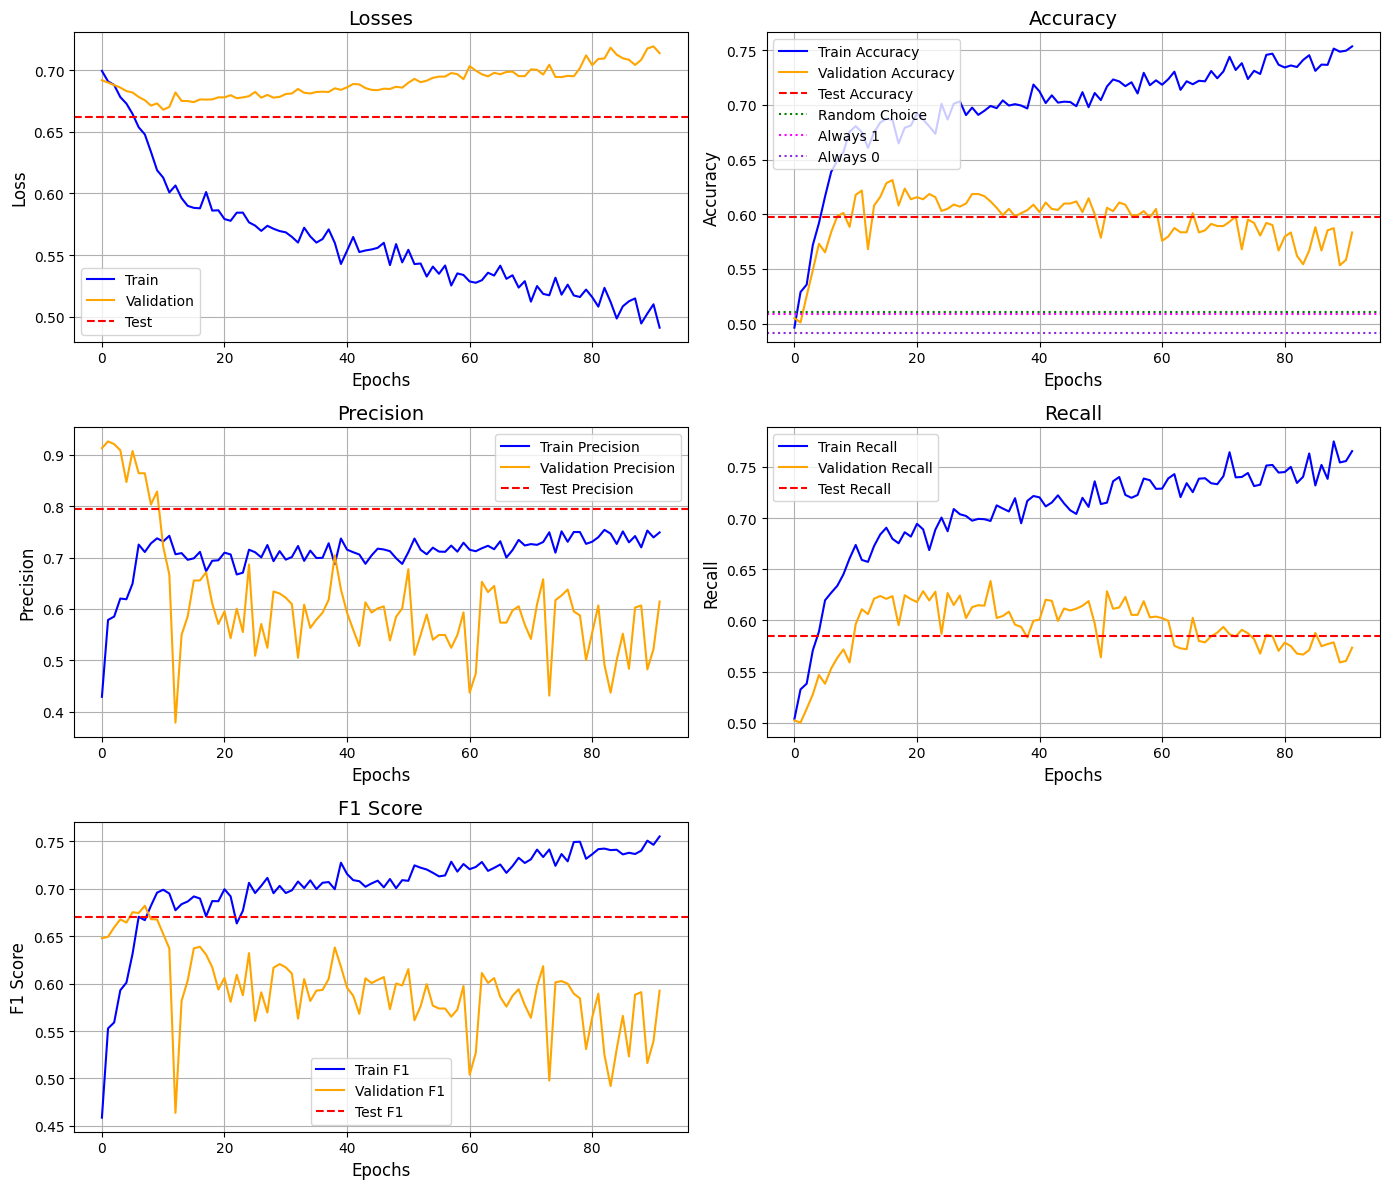

In [65]:
# Plot all the metrics evolution through the epochs of the GRU model

# Create a figure with 3 rows and 2 columns of subplots
fig, axis = plt.subplots(3, 2, figsize=(14, 12))

# Enhance the plot with grid lines, titles, labels, and different color
# Plot the loss evolution
axis[0, 0].set_title("Losses", fontsize=14)
axis[0, 0].plot(train_metrics_gru["train_losses"], label="Train", color='blue')
axis[0, 0].plot(valid_metrics_gru["val_losses"], label="Validation", color='orange')
axis[0, 0].axhline(test_loss_gru, linestyle='--', color='red', label='Test')
axis[0, 0].set_xlabel('Epochs', fontsize=12)
axis[0, 0].set_ylabel('Loss', fontsize=12)
axis[0, 0].legend()
axis[0, 0].grid(True)

# Plot the accuracy evolution
axis[0, 1].set_title("Accuracy", fontsize=14)
axis[0, 1].plot(train_metrics_gru["train_acc"], label="Train Accuracy", color='blue')
axis[0, 1].plot(valid_metrics_gru["val_acc"], label="Validation Accuracy", color='orange')
axis[0, 1].axhline(test_acc_gru, linestyle='--', color='red', label='Test Accuracy')
axis[0, 1].axhline(random_choice_accuracy, linestyle=':', color='green', label='Random Choice')
axis[0, 1].axhline(always_1_accuracy, linestyle=':', color='magenta', label='Always 1')
axis[0, 1].axhline(always_0_accuracy, linestyle=':', color='blueviolet', label='Always 0')
axis[0, 1].set_xlabel('Epochs', fontsize=12)
axis[0, 1].set_ylabel('Accuracy', fontsize=12)
axis[0, 1].legend()
axis[0, 1].grid(True)

# Plot the precision evolution
axis[1, 0].set_title("Precision", fontsize=14)
axis[1, 0].plot(train_metrics_gru["train_precision"], label="Train Precision", color='blue')
axis[1, 0].plot(valid_metrics_gru["val_precision"], label="Validation Precision", color='orange')
axis[1, 0].axhline(test_precision_gru, linestyle='--', color='red', label='Test Precision')
axis[1, 0].set_xlabel('Epochs', fontsize=12)
axis[1, 0].set_ylabel('Precision', fontsize=12)
axis[1, 0].legend()
axis[1, 0].grid(True)

# Plot the recall evolution
axis[1, 1].set_title("Recall", fontsize=14)
axis[1, 1].plot(train_metrics_gru["train_recall"], label="Train Recall", color='blue')
axis[1, 1].plot(valid_metrics_gru["val_recall"], label="Validation Recall", color='orange')
axis[1, 1].axhline(test_recall_gru, linestyle='--', color='red', label='Test Recall')
axis[1, 1].set_xlabel('Epochs', fontsize=12)
axis[1, 1].set_ylabel('Recall', fontsize=12)
axis[1, 1].legend()
axis[1, 1].grid(True)

# Plot the F1 score evolution
axis[2, 0].set_title("F1 Score", fontsize=14)
axis[2, 0].plot(train_metrics_gru["train_f1"], label="Train F1", color='blue')
axis[2, 0].plot(valid_metrics_gru["val_f1"], label="Validation F1", color='orange')
axis[2, 0].axhline(test_f1_gru, linestyle='--', color='red', label='Test F1')
axis[2, 0].set_xlabel('Epochs', fontsize=12)
axis[2, 0].set_ylabel('F1 Score', fontsize=12)
axis[2, 0].legend()
axis[2, 0].grid(True)

# Hide the unused subplot
axis[2, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()